# Trabajo Práctico: Exploración y Preparación de Airbnb Listings


## Objetivo
En esta libreta analizamos el dataset `listings_big.csv` para comprender su estructura, diagnosticar problemas de calidad y preparar un conjunto de features apto para estimar **qué tan alquilable es un listing**. El flujo general incluye:
- Exploración inicial y resumen estadístico
- Análisis de valores faltantes y patrones de disponibilidad
- Visualizaciones que permitan interpretar la ocupación y sus drivers
- Definición de un problema supervisado de clasificación enfocado en la alta ocupación
- Construcción de un pipeline de preprocesamiento, ingeniería de variables y selección/reducción de dimensionalidad


# 🏡 Airbnb Listings Data Dictionary

> Diccionario de datos del conjunto de listados de Airbnb, con tipos de datos, campos calculados y descripciones.  
> Compatible con visualización en GitHub (scroll horizontal automático en tablas grandes).

---

<div style="overflow-x: auto;">

| **Field** | **Type** | **Calculated** | **Description** |
|------------|-----------|----------------|-----------------|
| id | integer |  | Airbnb's unique identifier for the listing |
| listing_url | text | ✅ |  |
| scrape_id | bigint | ✅ | Inside Airbnb "Scrape" this was part of |
| last_scraped | datetime | ✅ | UTC. The date and time this listing was "scraped". |
| source | text |  | One of `"neighbourhood search"` or `"previous scrape"`. Describes how the listing was discovered. |
| name | text |  | Name of the listing |
| description | text |  | Detailed description of the listing |
| neighborhood_overview | text |  | Host's description of the neighbourhood |
| picture_url | text |  | URL to Airbnb-hosted regular-sized image |
| host_id | integer |  | Airbnb's unique identifier for the host/user |
| host_url | text | ✅ | Airbnb page for the host |
| host_name | text |  | Name of the host (usually first name). |
| host_since | date |  | Host account creation date |
| host_location | text |  | Host's self-reported location |
| host_about | text |  | Description about the host |
| host_response_time | text |  |  |
| host_response_rate | text |  |  |
| host_acceptance_rate | text |  | Rate at which host accepts booking requests |
| host_is_superhost | boolean *(t=true; f=false)* |  |  |
| host_thumbnail_url | text |  |  |
| host_picture_url | text |  |  |
| host_neighbourhood | text |  |  |
| host_listings_count | text |  | Number of listings (Airbnb internal) |
| host_total_listings_count | text |  | Total listings (Airbnb internal) |
| host_verifications | text |  |  |
| host_has_profile_pic | boolean *(t=true; f=false)* |  |  |
| host_identity_verified | boolean *(t=true; f=false)* |  |  |
| neighbourhood | text |  |  |
| neighbourhood_cleansed | text | ✅ | Geocoded neighbourhood (from shapefiles) |
| neighbourhood_group_cleansed | text | ✅ | Geocoded neighbourhood group (from shapefiles) |
| latitude | numeric |  | WGS84 latitude |
| longitude | numeric |  | WGS84 longitude |
| property_type | text |  | Self-selected property type |
| room_type | text |  | One of:<br>• **Entire home/apt** — Whole space<br>• **Private room** — Own room, shared areas<br>• **Shared room** — Shared sleeping space |
| accommodates | integer |  | Max guest capacity |
| bathrooms | numeric |  | Number of bathrooms |
| bathrooms_text | string |  | Text description of bathrooms (legacy field) |
| bedrooms | integer |  | Number of bedrooms |
| beds | integer |  | Number of beds |
| amenities | json |  | JSON array of amenities |
| price | currency |  | Daily price (ignore `$` artifact) |
| minimum_nights | integer |  | Minimum nights allowed |
| maximum_nights | integer |  | Maximum nights allowed |
| minimum_minimum_nights | integer | ✅ | Smallest min nights (calendar, 365 days ahead) |
| maximum_minimum_nights | integer | ✅ | Largest min nights (calendar, 365 days ahead) |
| minimum_maximum_nights | integer | ✅ | Smallest max nights (calendar, 365 days ahead) |
| maximum_maximum_nights | integer | ✅ | Largest max nights (calendar, 365 days ahead) |
| minimum_nights_avg_ntm | numeric | ✅ | Avg min nights (calendar, 365 days ahead) |
| maximum_nights_avg_ntm | numeric | ✅ | Avg max nights (calendar, 365 days ahead) |
| calendar_updated | date |  |  |
| has_availability | boolean |  | *(t=true; f=false)* |
| availability_30 | integer | ✅ | Available nights (next 30 days) |
| availability_60 | integer | ✅ | Available nights (next 60 days) |
| availability_90 | integer | ✅ | Available nights (next 90 days) |
| availability_365 | integer | ✅ | Available nights (next 365 days) |
| calendar_last_scraped | date |  |  |
| number_of_reviews | integer |  | Total number of reviews |
| number_of_reviews_ltm | integer | ✅ | Reviews in last 12 months |
| number_of_reviews_l30d | integer | ✅ | Reviews in last 30 days |
| first_review | date | ✅ | Date of first review |
| last_review | date | ✅ | Date of most recent review |
| review_scores_rating | numeric |  |  |
| review_scores_accuracy | numeric |  |  |
| review_scores_cleanliness | numeric |  |  |
| review_scores_checkin | numeric |  |  |
| review_scores_communication | numeric |  |  |
| review_scores_location | numeric |  |  |
| review_scores_value | numeric |  |  |
| license | text |  | Licence/permit/registration number |
| instant_bookable | boolean |  | *(t=true; f=false)* — Guests can book instantly |
| calculated_host_listings_count | integer | ✅ | Number of listings host has in this scrape (city/region) |
| calculated_host_listings_count_entire_homes | integer | ✅ | Entire homes owned by host |
| calculated_host_listings_count_private_rooms | integer | ✅ | Private rooms owned by host |
| calculated_host_listings_count_shared_rooms | integer | ✅ | Shared rooms owned by host |
| reviews_per_month | numeric | ✅ | Average reviews per month over listing lifetime.<br><br>**Pseudocode/SQL:**<br>`IF scrape_date - first_review <= 30 THEN number_of_reviews`<br>`ELSE number_of_reviews / ((scrape_date - first_review + 1) / (365/12))` |

</div>

---

✅ = Calculated field  
📘 *Boolean values*: `t=true`, `f=false`  
🌐 *Coordinates*: WGS84 projection  
💡 *Source*: [Inside Airbnb](http://insideairbnb.com/)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import ast
import re

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (8, 5)
pd.set_option('display.max_columns', 80)
pd.set_option("display.float_format", "{:.4f}".format)

DATA_PATH = Path('listings_big.csv')


## 1. Carga y saneamiento inicial


In [2]:
df_raw = pd.read_csv(
    DATA_PATH,
    na_values=("N/A", "NA", "na", "n/a", "", "-", ".","nan"),
    keep_default_na=True
)

df = df_raw.copy()
# Limpieza de precios: eliminar símbolos y convertir a numérico
df['price'] = (df['price']
               .astype(str)
               .str.replace(r'[€$£,]', '', regex=True)
               .str.strip())

df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Conversión de columnas fecha para posteriores features
date_columns = ['last_scraped', 'host_since', 'first_review', 'last_review']

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df['host_id'] = df['host_id'].astype('string')

print(f"Shape original: {df_raw.shape}")
print(f"Shape después de transformaciones básicas: {df.shape}")


Shape original: (35172, 79)
Shape después de transformaciones básicas: (35172, 79)


### 1.1 Información general del dataset


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35172 entries, 0 to 35171
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            35172 non-null  int64         
 1   listing_url                                   35172 non-null  object        
 2   scrape_id                                     35172 non-null  int64         
 3   last_scraped                                  35172 non-null  datetime64[ns]
 4   source                                        35172 non-null  object        
 5   name                                          35172 non-null  object        
 6   description                                   34294 non-null  object        
 7   neighborhood_overview                         16585 non-null  object        
 8   picture_url                                   35171 non-null  obje

In [4]:
# Resumen de tipos de columnas y conteo por tipo
type_summary = df.dtypes.value_counts().rename('count').to_frame()
type_summary


,count
object,30
int64,23
float64,21
datetime64[ns],4
string[python],1


In [5]:
# Estadísticas descriptivas de variables numéricas
def format_numeric_summary(df, exclude_patterns=("id",), currency_cols=None, decimals=4):
    # excluir columnas que no tienen sentido estadístico
    columns_to_exclude = [c for c in df.columns if any(pat in c.lower() for pat in exclude_patterns)]
    summary_num = (
        df.drop(columns=columns_to_exclude)
          .select_dtypes(include="number")
          .describe()
          .T
          .round(decimals)
    )

    # versión formateada
    summary_fmt = summary_num.copy().astype(object)

    # aplicar formato a las currency_cols
    if currency_cols:
        for col in currency_cols:
            if col in summary_fmt.index:
                summary_fmt.loc[col] = summary_num.loc[col].apply(lambda x: f"${x:,.{decimals}f}")

    return summary_num, summary_fmt

columns_to_exclude = ["id", "scrape_id", "host_id", "calendar_updated","neighbourhood_group_cleansed"]
currency_cols = ["price", "estimated_revenue_l365d"]

numeric_summary, numeric_summary_fmt = format_numeric_summary(
    df,
    exclude_patterns=columns_to_exclude,
    currency_cols=currency_cols,
    decimals=2
)

numeric_summary_fmt


,count,mean,std,min,25%,50%,75%,max
host_listings_count,35166.0000,19.5400,41.2900,1.0000,1.0000,3.0000,16.0000,670.0000
host_total_listings_count,35166.0000,29.4300,79.5800,1.0000,1.0000,4.0000,20.0000,2542.0000
latitude,35172.0000,-34.5900,0.0200,-34.6900,-34.6000,-34.5900,-34.5800,-34.5300
longitude,35172.0000,-58.4200,0.0300,-58.5300,-58.4400,-58.4200,-58.3900,-58.3600
accommodates,35172.0000,2.9400,1.5500,1.0000,2.0000,2.0000,4.0000,16.0000
bathrooms,31602.0000,1.2400,0.6600,0.0000,1.0000,1.0000,1.0000,22.0000
bedrooms,34445.0000,1.1900,0.9400,0.0000,1.0000,1.0000,1.0000,35.0000
beds,31604.0000,1.9100,1.6000,0.0000,1.0000,1.0000,2.0000,36.0000
price,"$31,598.00","$95,487.76","$1,402,656.42",$260.00,"$29,711.00","$39,908.00","$57,762.00","$105,021,704.00"
minimum_nights,35172.0000,6.1600,26.0700,1.0000,1.0000,2.0000,4.0000,1000.0000


In [6]:
# Estadísticas básicas de variables categóricas/cadenas
categorical_cols = df.select_dtypes(include=['object', 'string']).columns
categorical_summary = df[categorical_cols].describe().T
categorical_summary_sorted = categorical_summary.sort_values("freq", ascending=False)

categorical_summary_sorted.head(20)


,count,unique,top,freq
host_identity_verified,35166,2,t,34159
has_availability,34005,2,t,33940
host_has_profile_pic,35166,2,t,33717
room_type,35172,4,Entire home/apt,32083
source,35172,2,city scrape,31613
host_verifications,35166,7,"['email', 'phone']",28522
calendar_last_scraped,35172,4,2025-01-30,26254
property_type,35172,66,Entire rental unit,25470
bathrooms_text,35148,48,1 bath,25236
instant_bookable,35172,2,f,24046



### 1.2 Exploración de duplicados y consistencia


In [7]:
duplicate_count = df.duplicated(subset=['id']).sum()
print(f"Duplicados basados en 'id': {duplicate_count}")

missing_ids = df['id'].isna().sum()
print(f"IDs faltantes: {missing_ids}")


Duplicados basados en 'id': 0
IDs faltantes: 0


## 2. Valores faltantes


In [8]:
missing_abs = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_abs / len(df)).round(4)
missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct})
missing_table.head(20)


,missing,percent
neighbourhood_group_cleansed,35172,1.0000
calendar_updated,35172,1.0000
license,34783,0.9889
neighborhood_overview,18587,0.5285
neighbourhood,18584,0.5284
host_about,16360,0.4651
host_neighbourhood,13451,0.3824
host_location,7553,0.2147
review_scores_value,5761,0.1638
review_scores_accuracy,5761,0.1638


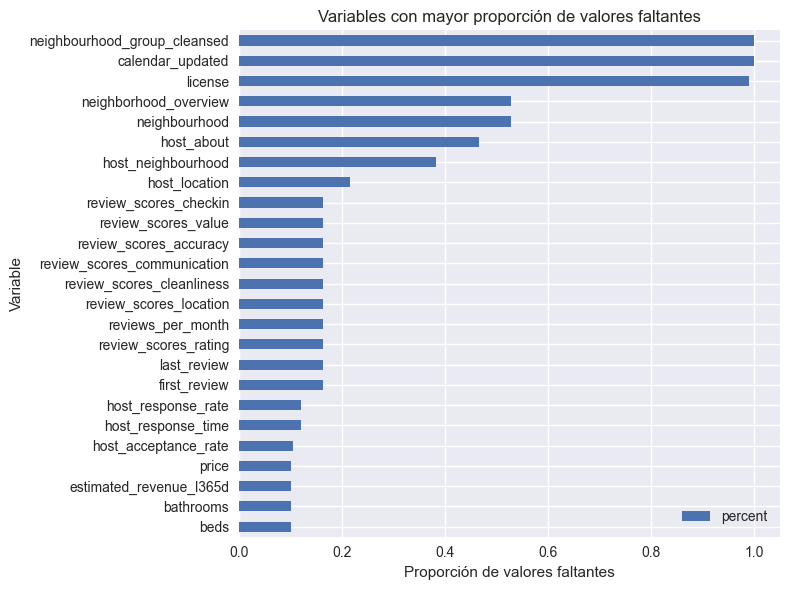

In [9]:
# Visualización del top de variables con mayor porcentaje de faltantes
top_missing = missing_table[missing_table['percent'] > 0].head(25)
ax = top_missing.sort_values('percent').plot.barh(y='percent', figsize=(8, 6))
ax.set_xlabel('Proporción de valores faltantes')
ax.set_ylabel('Variable')
ax.set_title('Variables con mayor proporción de valores faltantes')
plt.tight_layout()
plt.show()


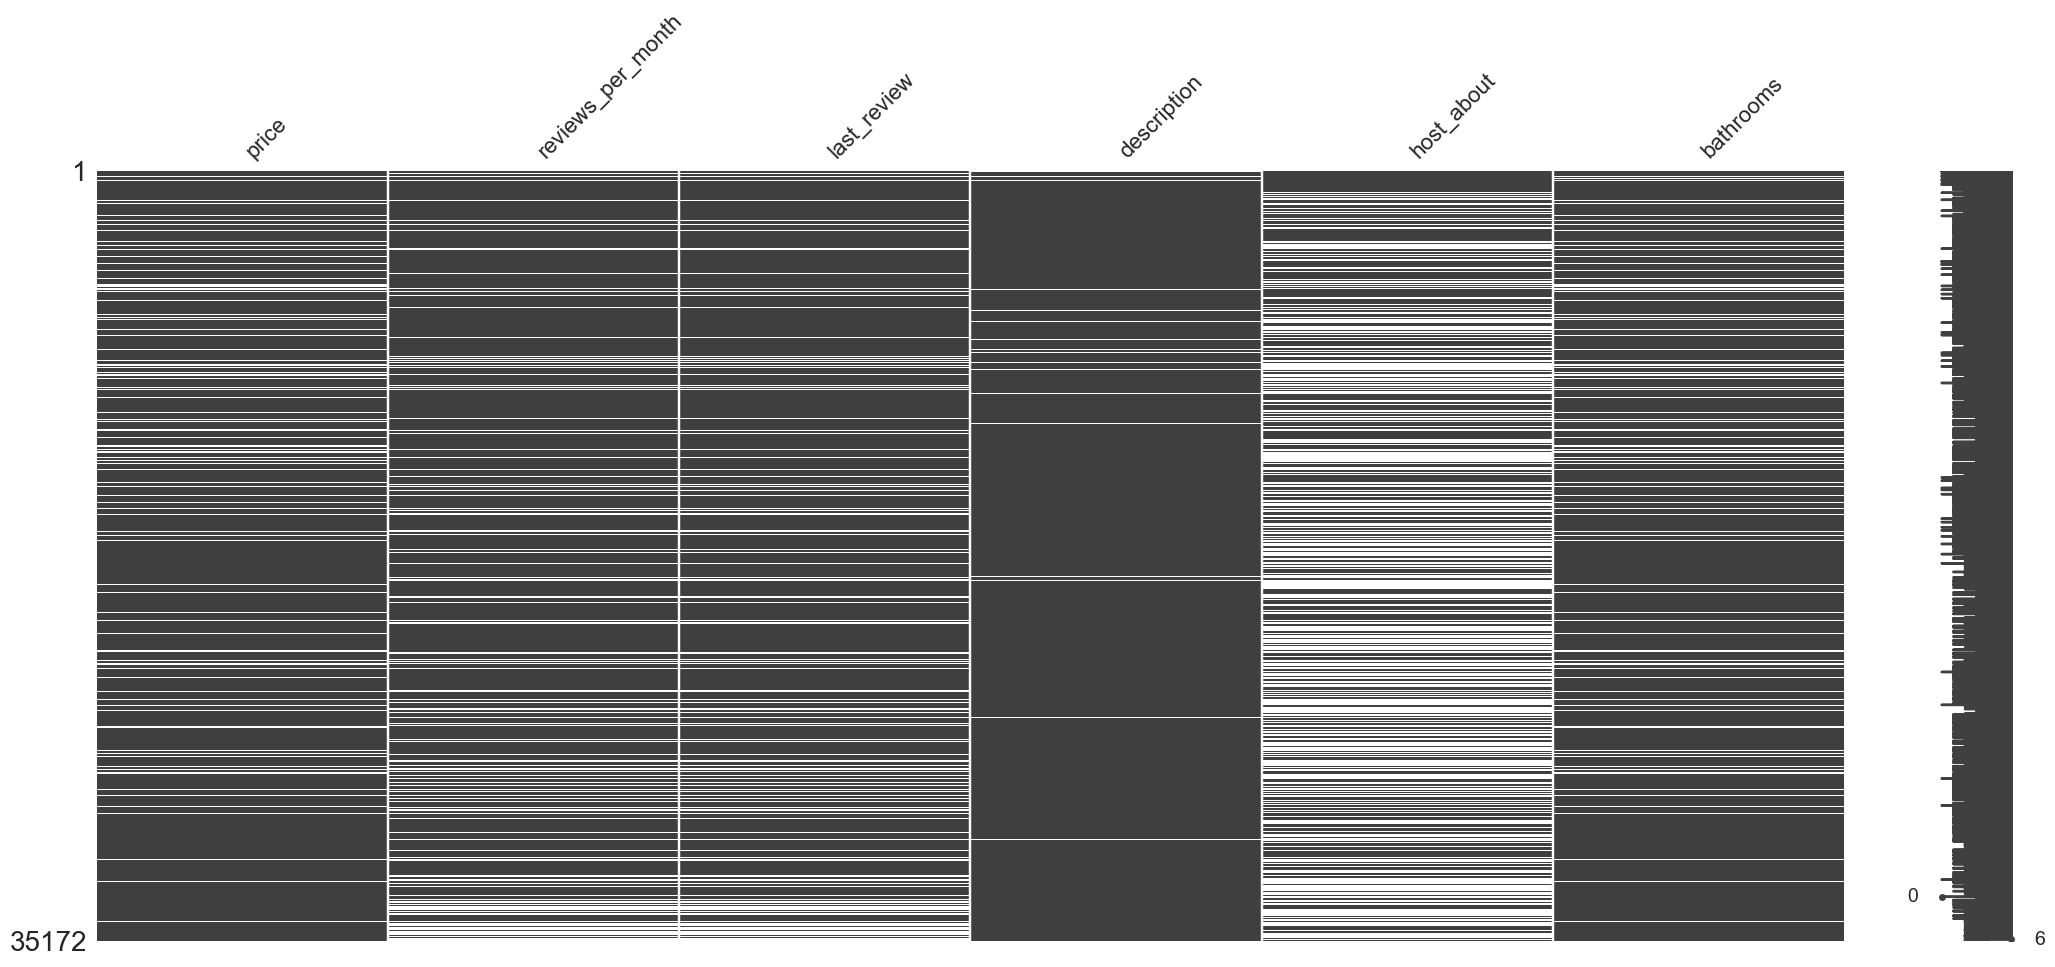

In [10]:
# Matriz de missingness para detectar patrones
try:
    import missingno as msno
    msno.matrix(df[['price', 'reviews_per_month', 'last_review', 'description', 'host_about', 'bathrooms']])
    plt.show()
except ImportError:
    print('missingno no está disponible en el entorno actual.')


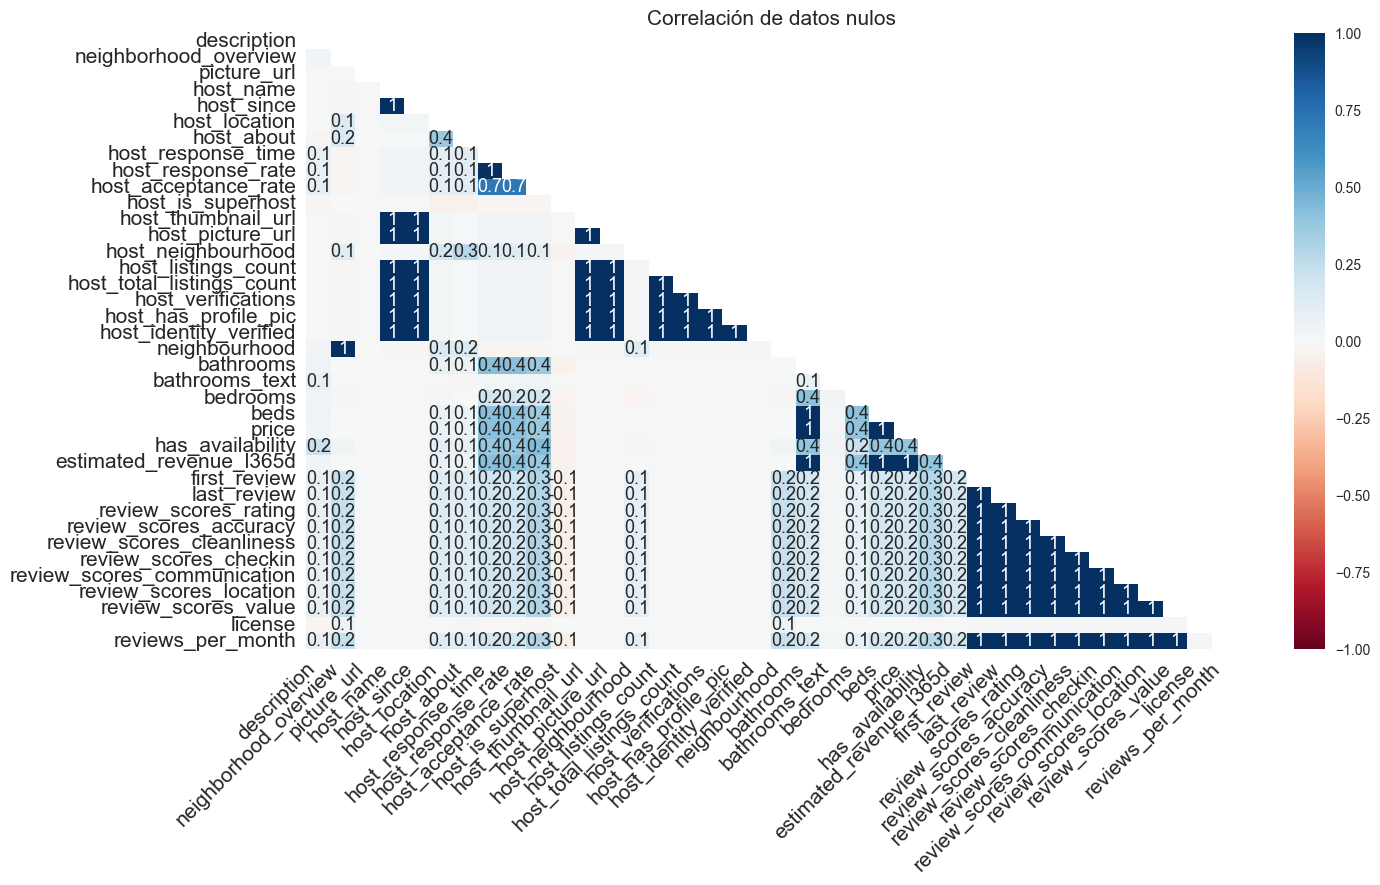

In [11]:
msno.heatmap(df, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()

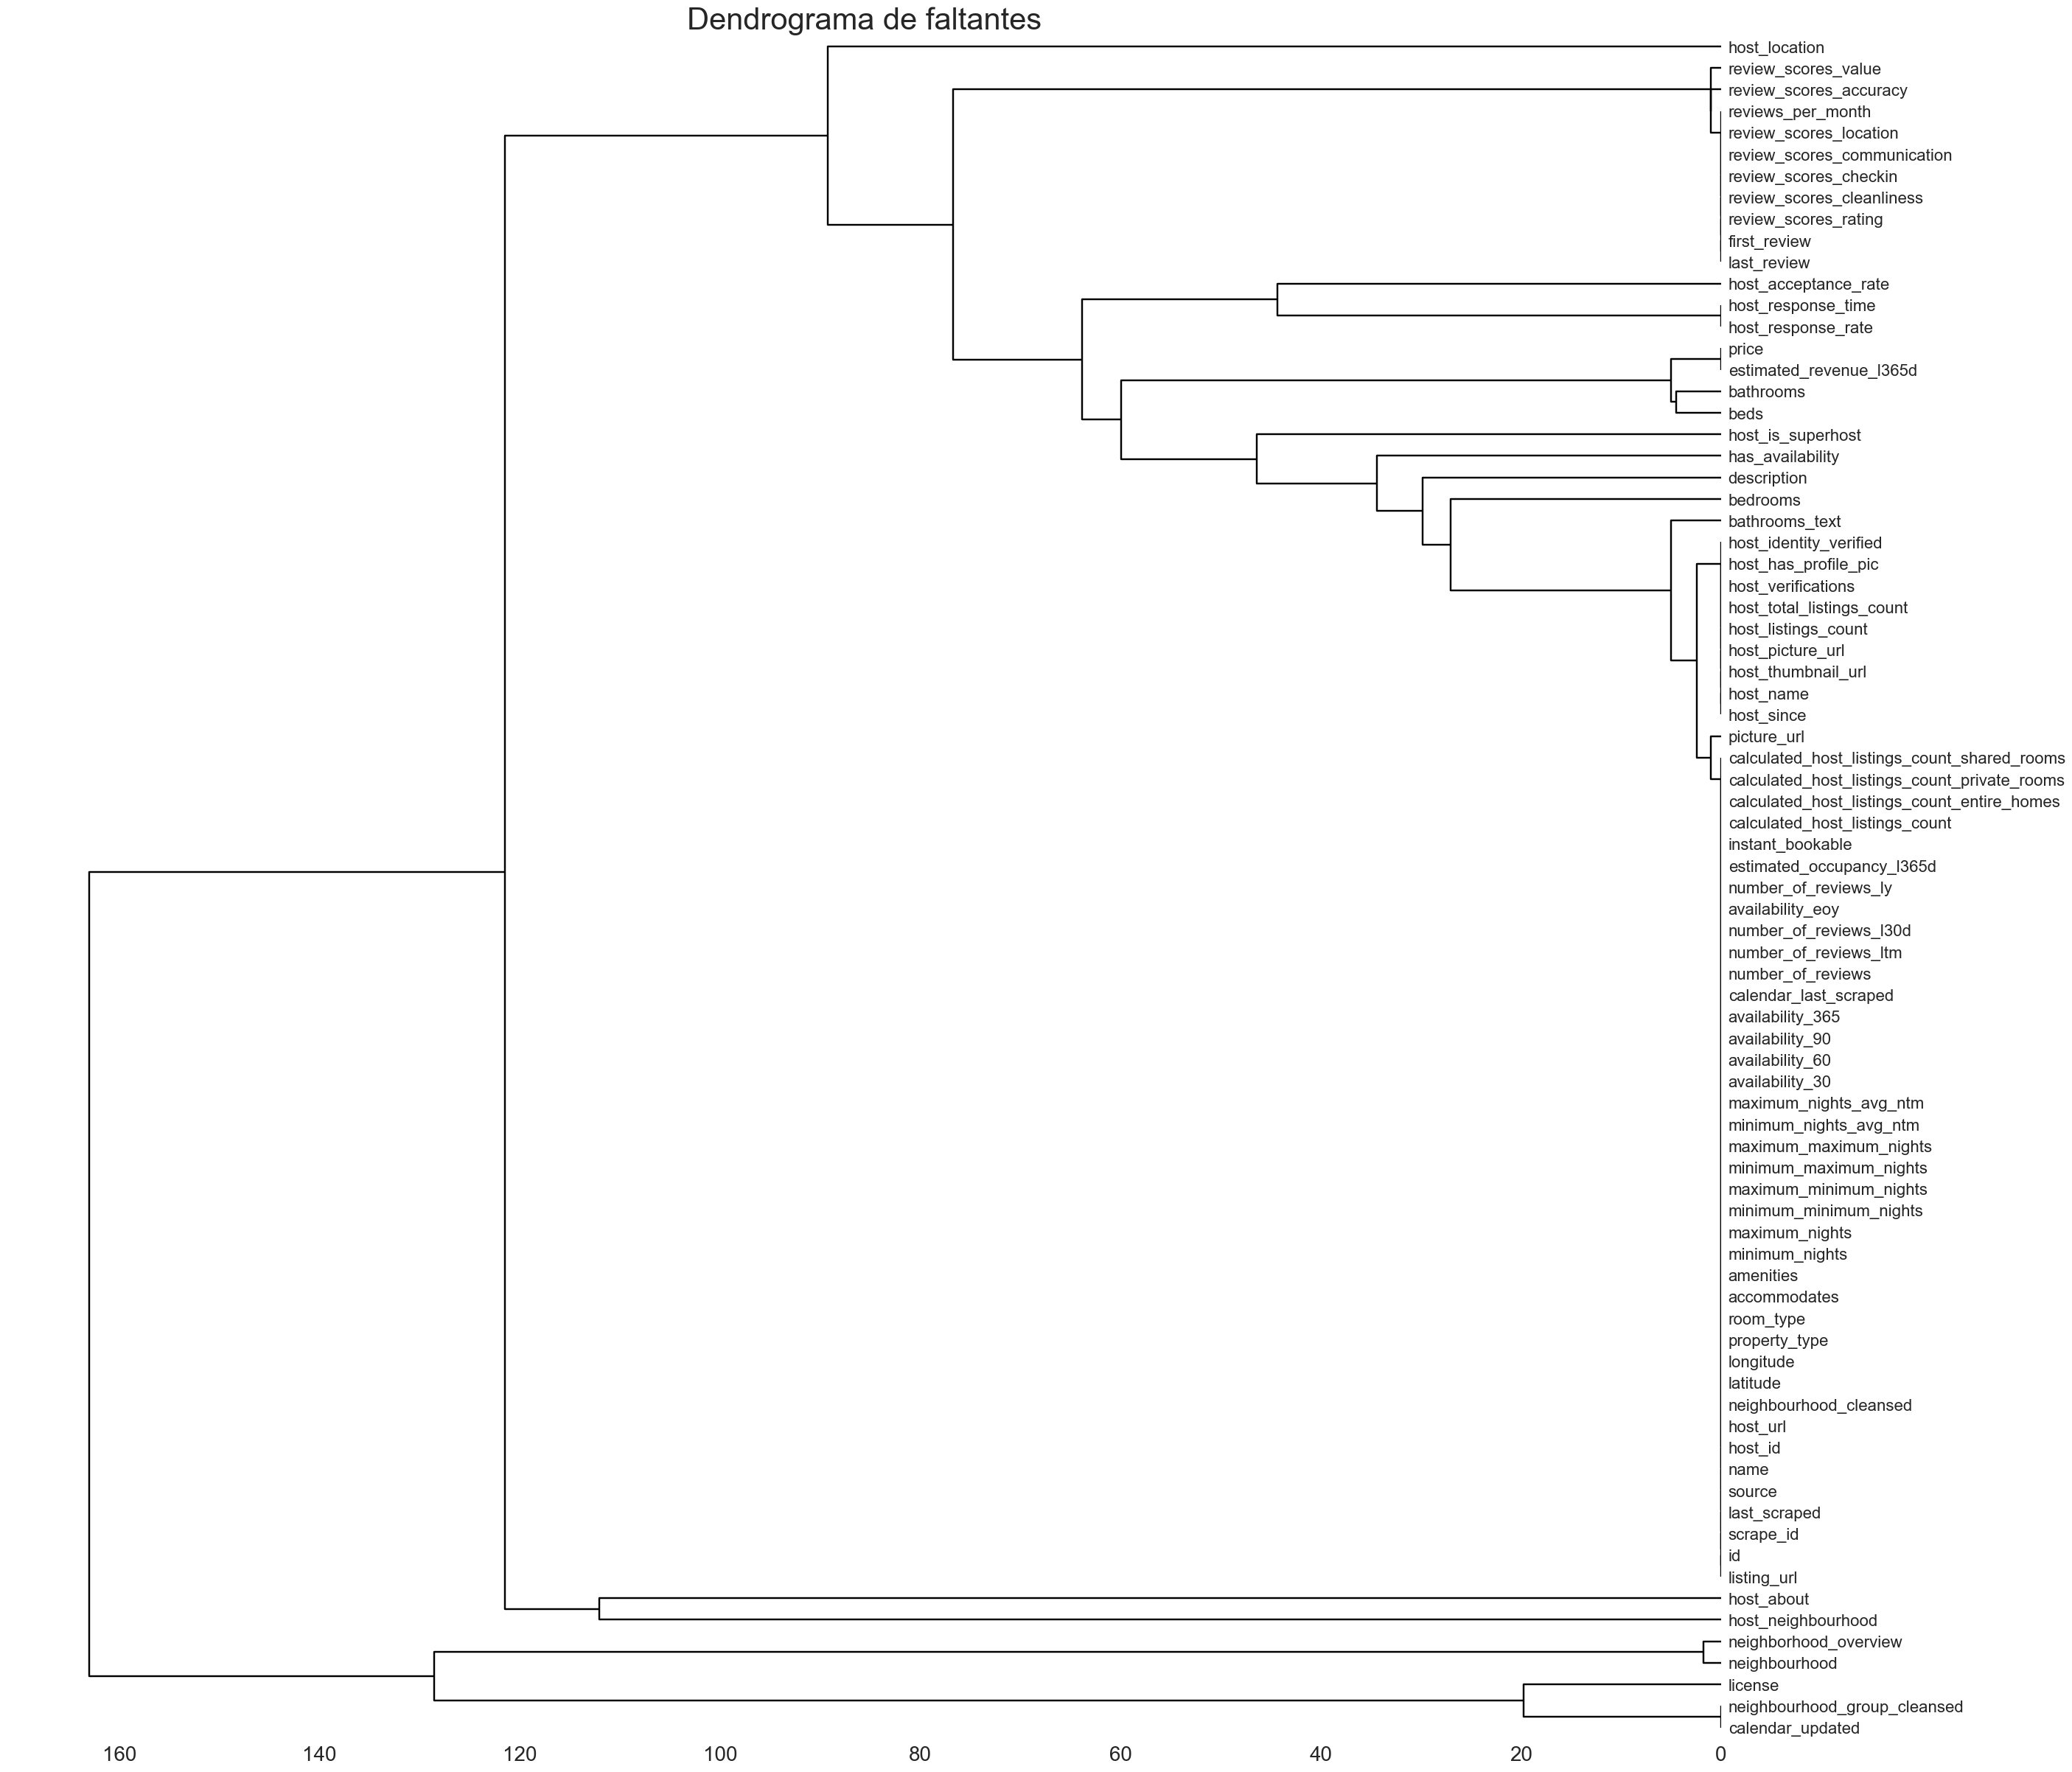

In [12]:
msno.dendrogram(df, figsize=(30,30))
plt.title('Dendrograma de faltantes', fontsize=30)
plt.show()

De aca podemos llegar a la conclusion de que

Las tres columnas con mas nulos son calendar_updated, neighbourhood_group_cleansed y license. Vemos que tienen relacion entre ellas, pero que con el resto de los datos no hay practicamente relacion.

In [13]:


# Helpers para detectar nulos SIN modificar el DataFrame 
NULL_TOKENS = {"", " ", "nan", "NaN", "null", "Null", "NULL", "none", "None", "NONE"}

def missing_mask(series: pd.Series) -> pd.Series:
    """True cuando el valor debe considerarse nulo (NaN real o string vacío)."""
    base_mask = series.isna()
    string_mask = series.astype(str).str.strip().isin(NULL_TOKENS)
    return base_mask | string_mask

# Construcción de features de referencia 
def build_numeric_features(df: pd.DataFrame, min_valid_frac: float = 0.50) -> dict:
    numeric_features = {}
    for col in df.columns:
        series = df[col]
        cleaned = (
            series.astype(str)
                  .str.replace(r"[^\d\.\-]", "", regex=True)
                  .replace("", pd.NA)
        )
        numeric = pd.to_numeric(cleaned, errors="coerce")
        if numeric.notna().mean() >= min_valid_frac:
            numeric_features[col] = numeric
    return numeric_features

def build_categorical_features(df: pd.DataFrame, max_cardinality: int = 30) -> dict:
    categorical_features = {}
    for col in df.columns:
        series = df[col]
        if series.dtype == "O" or series.dtype == "bool":
            if 1 <= series.dropna().nunique() <= max_cardinality:
                categorical_features[col] = series.fillna("Missing")
    return categorical_features

numeric_features = build_numeric_features(df)
categorical_features = build_categorical_features(df)

# Medidas de asociación entre patrón de nulos y otras columnas 
def numeric_effect(nan_mask: pd.Series, series: pd.Series):
    available = series.notna()
    if available.sum() == 0:
        return None
    miss = nan_mask & available
    present = (~nan_mask) & available
    if miss.sum() == 0 or present.sum() == 0:
        return None
    diff = series[miss].mean() - series[present].mean()
    std = series[available].std()
    if pd.isna(std) or std == 0:
        return None
    return abs(diff) / std  # diferencia estandarizada

def categorical_effect(nan_mask: pd.Series, series: pd.Series):
    miss = nan_mask
    present = ~nan_mask
    if miss.sum() == 0 or present.sum() == 0:
        return None
    freq_miss = series[miss].value_counts(normalize=True)
    freq_present = series[present].value_counts(normalize=True)
    combined = pd.concat([freq_miss, freq_present], axis=1, keys=["missing", "present"]).fillna(0)
    combined["diff"] = (combined["missing"] - combined["present"]).abs()
    return combined["diff"].max()

# Clasificación MCAR / MAR / MNAR / Estructural 
missing_counts = {col: missing_mask(df[col]).sum() for col in df.columns}
missing_pct = {col: round(count / len(df) * 100, 2) for col, count in missing_counts.items()}
missing_summary = (
    pd.DataFrame({"missing": missing_counts, "missing_pct": missing_pct})
      .query("missing > 0")
      .sort_values("missing_pct", ascending=False)
)

results = []
row_count = len(df)

for col in missing_summary.index:
    mask = missing_mask(df[col])

    if missing_summary.loc[col, "missing"] == row_count:
        results.append({
            "column": col,
            "missing": missing_summary.loc[col, "missing"],
            "missing_pct": missing_summary.loc[col, "missing_pct"],
            "category": "Estructural",
            "driver": None,
            "effect_size": None,
            "notes": "100% ausente en el scrape; indicio de campo no disponible en la fuente."
        })
        continue

    best_effect = 0
    best_driver = None
    best_type = None

    for driver, series in numeric_features.items():
        if driver == col:
            continue
        effect = numeric_effect(mask, series)
        if effect is not None and effect > best_effect:
            best_effect = effect
            best_driver = driver
            best_type = "numérico"

    for driver, series in categorical_features.items():
        if driver == col:
            continue
        effect = categorical_effect(mask, series)
        if effect is not None and effect > best_effect:
            best_effect = effect
            best_driver = f"{driver} (categoría)"
            best_type = "categórico"

    if best_effect < 0.05 or best_driver is None:
        category = "MCAR"
        notes = "No se detectan asociaciones significativas con variables observadas."
    else:
        if missing_summary.get("missing_pct", pd.Series()).get(best_driver.replace(" (categoría)", ""), 0) < 50:
            category = "MAR"
            notes = f"Patrón de ausencias relacionado con {best_driver}; efecto {best_effect:.2f} ({best_type})."
        else:
            category = "MNAR"
            notes = (
                f"Hay asociación (efecto {best_effect:.2f}) pero el driver también está muy incompleto "
                "o depende de factores no observados; se clasifica como MNAR."
            )

    results.append({
        "column": col,
        "missing": missing_summary.loc[col, "missing"],
        "missing_pct": missing_summary.loc[col, "missing_pct"],
        "category": category,
        "driver": best_driver,
        "effect_size": round(best_effect, 3) if best_effect is not None else None,
        "notes": notes
    })

missing_classification = pd.DataFrame(results).sort_values(["category", "missing_pct"], ascending=False)
missing_classification


,column,missing,missing_pct,category,driver,effect_size,notes
2,license,34783,98.8900,MAR,id,0.9990,Patrón de ausencias relacionado con id; efecto...
3,neighborhood_overview,18587,52.8500,MAR,id,0.8110,Patrón de ausencias relacionado con id; efecto...
4,neighbourhood,18584,52.8400,MAR,id,0.8110,Patrón de ausencias relacionado con id; efecto...
5,host_about,16372,46.5500,MAR,host_id,0.6770,Patrón de ausencias relacionado con host_id; e...
6,host_neighbourhood,13451,38.2400,MAR,host_id,0.6480,Patrón de ausencias relacionado con host_id; e...
7,host_location,7553,21.4700,MAR,host_id,1.0280,Patrón de ausencias relacionado con host_id; e...
8,review_scores_location,5760,16.3800,MAR,host_acceptance_rate,1.0790,Patrón de ausencias relacionado con host_accep...
9,review_scores_communication,5760,16.3800,MAR,host_acceptance_rate,1.0790,Patrón de ausencias relacionado con host_accep...
10,review_scores_cleanliness,5760,16.3800,MAR,host_acceptance_rate,1.0790,Patrón de ausencias relacionado con host_accep...
11,review_scores_accuracy,5761,16.3800,MAR,review_scores_cleanliness,9.7900,Patrón de ausencias relacionado con review_sco...


**Interpretación inicial:** La ausencia de `reviews_per_month` suele darse en listados sin reseñas recientes, sugiriendo un mecanismo MAR (dependiente de `number_of_reviews`).


## 2.1 Tratamiento de nulos

### 2.1.1 Las columnas

- neighbourhood_group_cleansed (100% nulos)
- calendar_updated (100% nulos)
- license (99% nulos)

las eliminamos

In [14]:
df = df.drop(columns=['neighbourhood_group_cleansed', 'calendar_updated','license'] )

### 2.1.2 La columna booleanas

- Si has_availability es nula, la completamos con yes si la suma de availability_30, availability_60, availability_90 y availability_365 es distinta de cero y con no si la suma es igual a cero
- Si host_is_superhost no esta definida, significa que puede ser un listing nuevo que aun no fue evaluado por airbnb para ver si califica o no, con lo cual es importante diferenciar de un no. Para eso a los nulos le ponemos no, pero creamos una nueva columna llamada was_evaluated_for_superhost para diferenciarlos de los ya evaluados

In [15]:
cols_sumar = ['availability_30','availability_60', 'availability_90', 'availability_365']

df.loc[
    (df[cols_sumar].sum(axis=1) != 0) & (df['has_availability'].isna()),
    'has_availability'
] = 't'

df.loc[
    (df[cols_sumar].sum(axis=1) == 0) & (df['has_availability'].isna()),
    'has_availability'
] = 'f'

for col in ['host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'has_availability']:
    if col in df.columns:
        df[col] = df[col].replace({'t': 'yes', 'f': 'no'})

# is_superhost

df['was_evaluated_for_superhost'] = ~df['host_is_superhost'].isna()
df['host_is_superhost'] = df['host_is_superhost'].map({'t': 'yes', 'f': 'no'}).fillna('no')

print(df['host_is_superhost'].unique())

print(df['was_evaluated_for_superhost'].unique())


['yes' 'no']
[ True False]


### 2.1.2 Las columnas neighbourhood (52% nulos), neighbourhood_overview (52% nulos), host_location (46% nulos) y host_about (46% nulos)

- La columna neighbourhood completamos con la del valor codificado neighbourhood_cleansed que es el valor ya codificado de la ubicacion
- La columna neighbourhood_overview le asignamos la clasificacion "not defined"
- La columna host_location y host_about le asignamos la clasificacion "not defined"


In [16]:
df['neighbourhood'] = df['neighbourhood'].fillna(df['neighbourhood_cleansed'])

cols = ['neighborhood_overview', 'host_location', 'host_about','host_neighbourhood']

for col in cols:
    df[col] = (
        df[col]
            .astype('string')                         # convierte a string (dtype nativo)
            .replace(r'^\s*$', pd.NA, regex=True)     # "" o espacios → NA
            .fillna('not-defined')                    # completa NA
    )

missing_abs = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_abs / len(df)).round(4)
missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct*100})
missing_table[missing_table["missing"]>0].head(79)


,missing,percent
review_scores_accuracy,5761,16.3800
review_scores_value,5761,16.3800
last_review,5760,16.3800
reviews_per_month,5760,16.3800
review_scores_cleanliness,5760,16.3800
review_scores_checkin,5760,16.3800
first_review,5760,16.3800
review_scores_rating,5760,16.3800
review_scores_location,5760,16.3800
review_scores_communication,5760,16.3800


### 2.1.2 Las columnas neighbourhood (52% nulos), neighbourhood_overview (52% nulos), host_location (46% nulos) y host_about (46% nulos)

Podemos observar que el porcentaje de nulos de las columnas asociadas a las reviews es el mismo (16.7%) y coincide con que no hay ni fecha de first_review ni fecha de last_review, esto nos muestra que posiblemente esos listings aun no tengan ninguna review asociada, con lo cual tiene sentido que sean nulos las reviews por aspecto del alojamiento. Lo que vamos a hacer es asignarle un cero pero ademas vamos a crear una nueva columna que indique si el listing tiene reviews o no.

- review_scores_accuracy	    4725	16.7600
- review_scores_value	        4725	16.7600
- reviews_per_month	            4724	16.7600
- first_review	                4724	16.7600
- last_review	                4724	16.7600
- review_scores_rating	        4724	16.7600
- review_scores_location	    4724	16.7600
- review_scores_communication	4724	16.7600
- review_scores_checkin	        4724	16.7600
- review_scores_cleanliness	    4724	16.7600


In [17]:
cols_scores = [
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'review_scores_rating'
]

# 1) Definir fecha de referencia para calcular la  cantidad de dias desde la ultima review en base al maximo

reference_date = max(df['first_review'].max(), df['last_review'].max())

print("Fecha de referencia:", reference_date)

for c in cols_scores:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# 2) Flag "tiene reviews"

has_num_reviews = df['number_of_reviews'] > 0 if 'number_of_reviews' in df.columns else False
has_first = df['first_review'].notna() if 'first_review' in df.columns else False
has_last  = df['last_review'].notna()  if 'last_review'  in df.columns else False
has_rpm   = (df['reviews_per_month'].fillna(0) > 0) if 'reviews_per_month' in df.columns else False

df['has_reviews'] = (has_num_reviews | has_first | has_last | has_rpm).astype(bool)

# 3) Poner 0 en scores solo cuando no hay reviews
df.loc[~df['has_reviews'], [c for c in cols_scores if c in df.columns]] = 0

# 3) Crear días desde primera review
df['days_since_first_review'] = np.where(
    df['has_reviews'] == 1,
    (reference_date - df['first_review']).dt.days,
    -1  # -1 indica que no tiene reviews
)

# 4) Crear días desde última review
df['days_since_last_review'] = np.where(
    df['has_reviews'] == 1,
    (reference_date - df['last_review']).dt.days,
    -1
)

if 'reviews_per_month' in df.columns:
    df.loc[~df['has_reviews'] & df['reviews_per_month'].isna(), 'reviews_per_month'] = 0.0

df.drop(columns=['first_review', 'last_review'], inplace=True)

missing_abs = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_abs / len(df)).round(4)
missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct*100})
missing_table[missing_table["missing"]>0].head(79)

Fecha de referencia: 2025-01-30 00:00:00


,missing,percent
host_response_rate,4229,12.0200
host_response_time,4229,12.0200
host_acceptance_rate,3712,10.5500
price,3574,10.1600
estimated_revenue_l365d,3574,10.1600
bathrooms,3570,10.1500
beds,3568,10.1400
description,878,2.5000
bedrooms,727,2.0700
bathrooms_text,24,0.0700


### 2.1.3 Chequeo de nulos antes del split

Nulos previos al split con pre procesamiento de nulos

In [18]:
missing_abs = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_abs / len(df)).round(4)
missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct})
missing_table.head(20)


,missing,percent
host_response_rate,4229,0.1202
host_response_time,4229,0.1202
host_acceptance_rate,3712,0.1055
price,3574,0.1016
estimated_revenue_l365d,3574,0.1016
bathrooms,3570,0.1015
beds,3568,0.1014
description,878,0.0250
bedrooms,727,0.0207
bathrooms_text,24,0.0007


### 2.1.4 Split del dataset

Tenemos en cuenta de que todos los listing del mismo host no queden divididos
Spliteamos en este punto para evitar dataleakage

In [19]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['host_id']))

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# sanity check: no hay host_id compartidos
assert set(df_train.host_id) & set(df_test.host_id) == set()

print(df.shape, df_test.shape, df_train.shape)

(35172, 78) (6988, 78) (28184, 78)


## 3. Distribuciones y visualizaciones clave


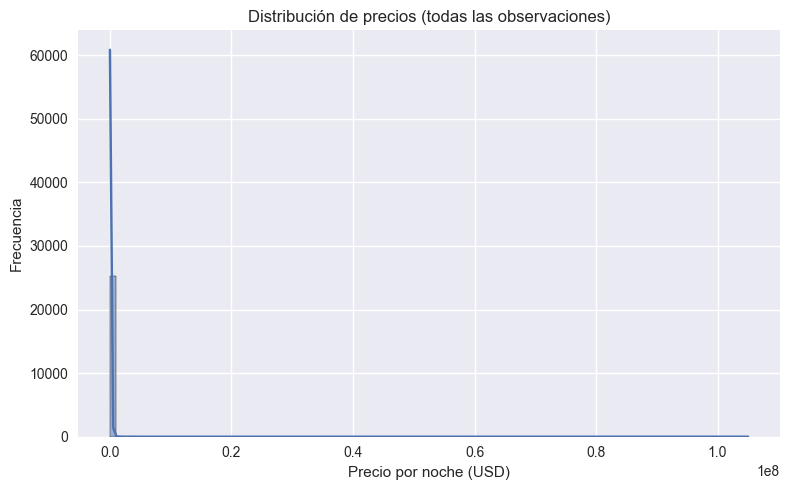

In [20]:
sns.histplot(df_train['price'].dropna(), bins=100, kde=True)
plt.title('Distribución de precios (todas las observaciones)')
plt.xlabel('Precio por noche (USD)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


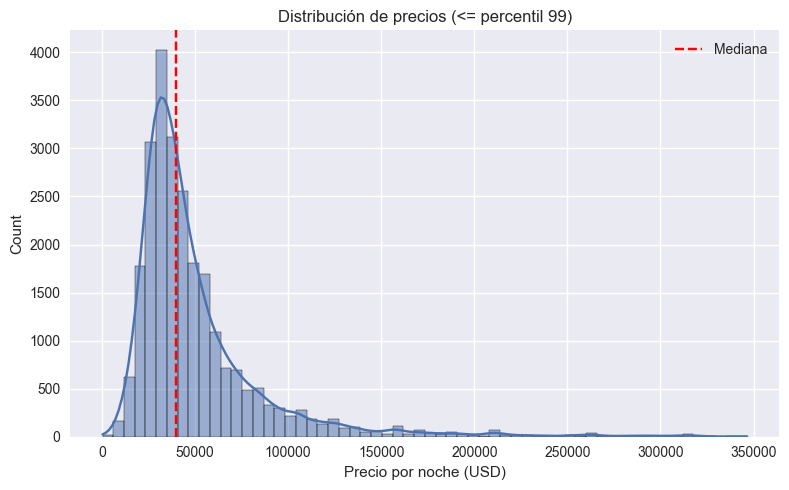

In [21]:
# Distribución recortando el 1% superior para atenuar outliers
price_cap = df_train['price'].quantile(0.99)
sns.histplot(df_train.loc[df['price'] <= price_cap, 'price'], bins=60, kde=True)
plt.axvline(df_train['price'].median(), color='red', linestyle='--', label='Mediana')
plt.title('Distribución de precios (<= percentil 99)')
plt.xlabel('Precio por noche (USD)')
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# Skewness de precios para evaluar la asimetría
price_series = df_train['price'].dropna()
price_skew = price_series.skew()
positive_prices = price_series[price_series > 0]
price_log_skew = np.log1p(positive_prices).skew() if not positive_prices.empty else np.nan
print(f'Skewness (precio bruto): {price_skew:.3f}')
print(f'Skewness (log1p del precio): {price_log_skew:.3f}')


Skewness (precio bruto): 52.733
Skewness (log1p del precio): 1.780


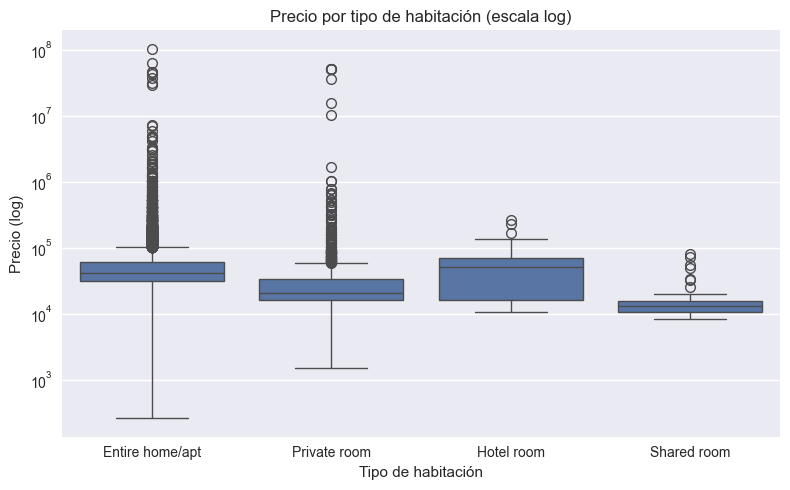

In [23]:
sns.boxplot(data=df_train, x='room_type', y='price')
plt.yscale('log')
plt.title('Precio por tipo de habitación (escala log)')
plt.xlabel('Tipo de habitación')
plt.ylabel('Precio (log)')
plt.tight_layout()
plt.show()


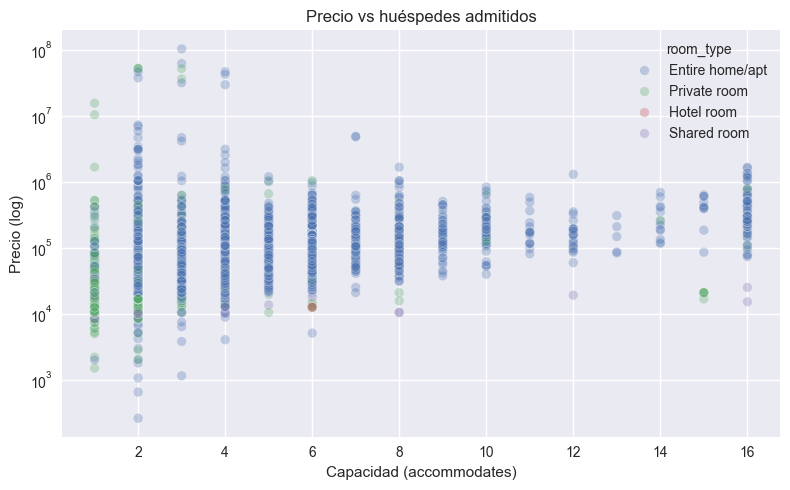

In [24]:
# Precio vs capacidad
sns.scatterplot(data=df_train, x='accommodates', y='price', hue='room_type', alpha=0.3)
plt.yscale('log')
plt.title('Precio vs huéspedes admitidos')
plt.xlabel('Capacidad (accommodates)')
plt.ylabel('Precio (log)')
plt.tight_layout()
plt.show()


### Distribuciones de disponibilidad y ocupación


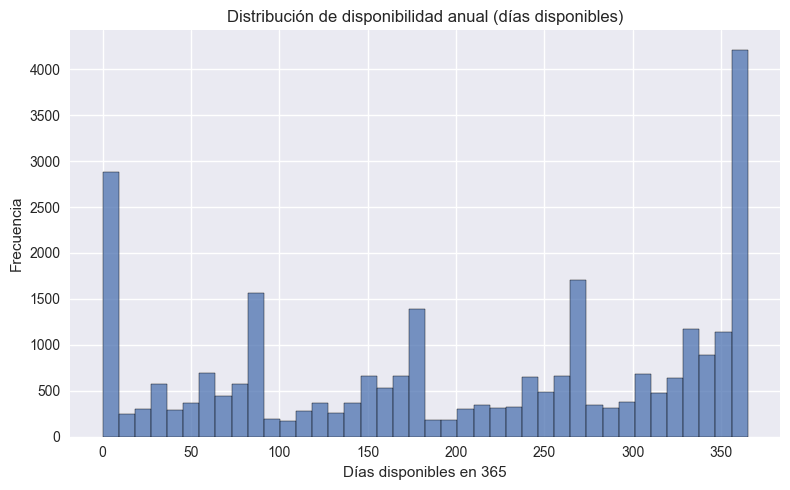

In [25]:
sns.histplot(df_train['availability_365'], bins=40, kde=False)
plt.title('Distribución de disponibilidad anual (días disponibles)')
plt.xlabel('Días disponibles en 365')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


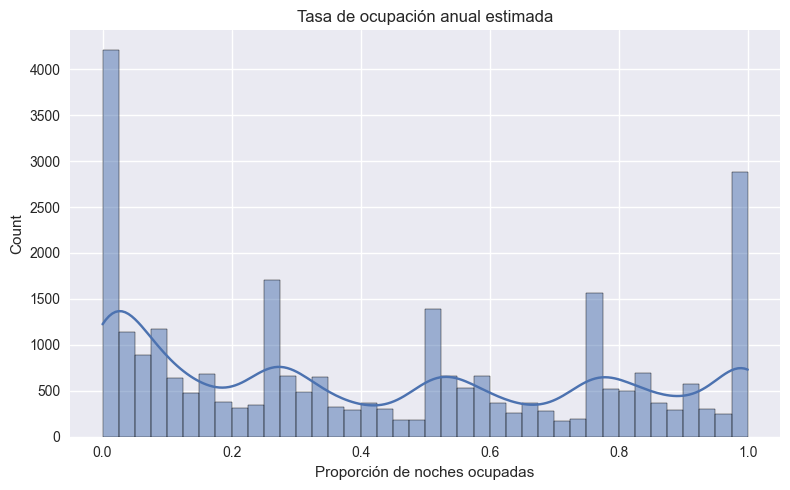

In [26]:
sns.histplot(1 - (df_train['availability_365'] / 365), bins=40, kde=True)
plt.title('Tasa de ocupación anual estimada')
plt.xlabel('Proporción de noches ocupadas')
plt.tight_layout()
plt.show()


### Correlación orientada a disponibilidad (categóricas codificadas)
Para estudiar los drivers de disponibilidad aplicamos one-hot encoding sobre las variables categóricas y analizamos la correlación con las tasas de ocupación.


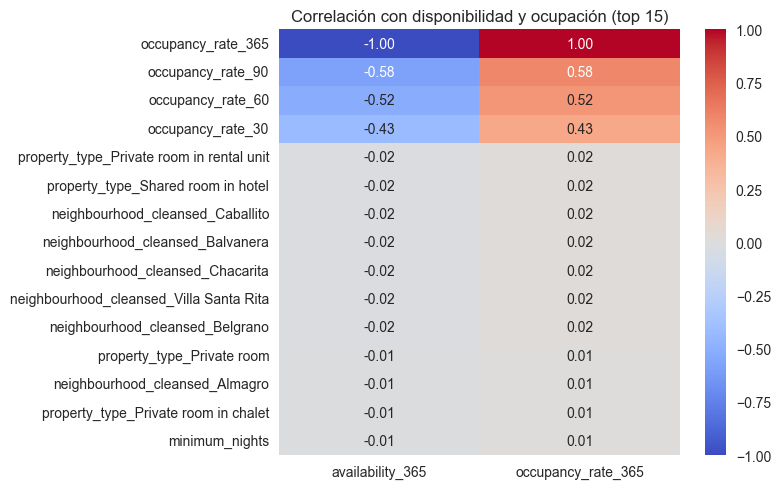

,availability_365,occupancy_rate_365
occupancy_rate_365,-1.0000,1.0000
occupancy_rate_90,-0.5818,0.5818
occupancy_rate_60,-0.5210,0.5210
occupancy_rate_30,-0.4274,0.4274
property_type_Private room in rental unit,-0.0227,0.0227
property_type_Shared room in hotel,-0.0207,0.0207
neighbourhood_cleansed_Caballito,-0.0183,0.0183
neighbourhood_cleansed_Balvanera,-0.0170,0.0170
neighbourhood_cleansed_Chacarita,-0.0167,0.0167
neighbourhood_cleansed_Villa Santa Rita,-0.0162,0.0162


In [27]:
# Codificación de categóricas para matriz de correlación orientada a disponibilidad
availability_cols = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
base_columns = ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
                'number_of_reviews', 'reviews_per_month', 'price']

corr_base = df_train[base_columns + availability_cols].copy()

for horizon in [30, 60, 90, 365]:
    rate_col = f'occupancy_rate_{horizon}'
    if rate_col not in df_train.columns:
        df_train[rate_col] = 1 - (df_train[f'availability_{horizon}'] / horizon)
    corr_base[rate_col] = df_train[rate_col]

binary_map = {'yes': 1, 'no': 0}
for col in ['host_is_superhost', 'instant_bookable']:
    corr_base[f'{col}_flag'] = df_train[col].map(binary_map)

categorical_for_corr = ['room_type', 'property_type', 'neighbourhood_cleansed']
corr_encoded = pd.get_dummies(
    pd.concat([corr_base, df_train[categorical_for_corr]], axis=1),
    columns=categorical_for_corr,
    drop_first=True
)

corr_matrix = corr_encoded.corr(numeric_only=True)
target_corr = corr_matrix[['availability_365', 'occupancy_rate_365']].sort_values(
    by='occupancy_rate_365', ascending=False
)

top_features = target_corr.head(15).index
sns.heatmap(
    corr_matrix.loc[top_features, ['availability_365', 'occupancy_rate_365']],
    annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1
)
plt.title('Correlación con disponibilidad y ocupación (top 15)')
plt.tight_layout()
plt.show()

target_corr.head(15)


## 4. Disponibilidad y objetivo de ocupación


In [28]:
# Cálculo de tasas de ocupación a partir de la disponibilidad
availability_cols = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
occupancy_df = df_train[availability_cols].copy()

for horizon in [30, 60, 90, 365]:
    rate_col = f'occupancy_rate_{horizon}'
    df_train[rate_col] = 1 - (df_train[f'availability_{horizon}'] / horizon)
    occupancy_df[rate_col] = df_train[rate_col]

occupancy_summary = occupancy_df[[f'occupancy_rate_{h}' for h in [30, 60, 90, 365]]].describe().T
print(occupancy_summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']])

# Target multiclase basado en la tasa anual
bins = [0.0, 0.4, 0.7, 1.01]
labels = ['low', 'mid', 'high']
df_train['occupancy_level'] = pd.cut(
    df_train['occupancy_rate_365'].clip(lower=0, upper=1),
    bins=bins, labels=labels, right=False, include_lowest=True
)

level_counts = df_train['occupancy_level'].value_counts(dropna=False).sort_index()
print('Distribución de occupancy_level:')
print(level_counts)
print('Proporciones:')
print((level_counts / len(df_train)).round(3))


                     mean    std    min    25%    50%    75%    max
occupancy_rate_30  0.5103 0.4014 0.0000 0.0667 0.5000 1.0000 1.0000
occupancy_rate_60  0.4463 0.3804 0.0000 0.0500 0.3833 0.8500 1.0000
occupancy_rate_90  0.3941 0.3671 0.0000 0.0444 0.3000 0.6889 1.0000
occupancy_rate_365 0.4360 0.3459 0.0000 0.0904 0.3753 0.7589 1.0000
Distribución de occupancy_level:
occupancy_level
low     14369
mid      5535
high     8280
Name: count, dtype: int64
Proporciones:
occupancy_level
low    0.5100
mid    0.1960
high   0.2940
Name: count, dtype: float64


In [29]:
# replica para df_test
occupancy_df = df_test[availability_cols].copy()

for horizon in [30, 60, 90, 365]:
    rate_col = f'occupancy_rate_{horizon}'
    df_test[rate_col] = 1 - (df_test[f'availability_{horizon}'] / horizon)
    occupancy_df[rate_col] = df_test[rate_col]

occupancy_summary = occupancy_df[[f'occupancy_rate_{h}' for h in [30, 60, 90, 365]]].describe().T
print(occupancy_summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']])

# Target multiclase basado en la tasa anual
bins = [0.0, 0.4, 0.7, 1.01]
labels = ['low', 'mid', 'high']
df_test['occupancy_level'] = pd.cut(
    df_test['occupancy_rate_365'].clip(lower=0, upper=1),
    bins=bins, labels=labels, right=False, include_lowest=True
)

level_counts = df_test['occupancy_level'].value_counts(dropna=False).sort_index()
print('Distribución de occupancy_level:')
print(level_counts)
print('Proporciones:')
print((level_counts / len(df_test)).round(3))

                     mean    std    min    25%    50%    75%    max
occupancy_rate_30  0.5077 0.3992 0.0000 0.0667 0.5000 1.0000 1.0000
occupancy_rate_60  0.4434 0.3763 0.0000 0.0500 0.3833 0.8167 1.0000
occupancy_rate_90  0.3911 0.3616 0.0000 0.0444 0.3000 0.6889 1.0000
occupancy_rate_365 0.4256 0.3451 0.0000 0.0849 0.3452 0.7562 1.0000
Distribución de occupancy_level:
occupancy_level
low     3678
mid     1299
high    2011
Name: count, dtype: int64
Proporciones:
occupancy_level
low    0.5260
mid    0.1860
high   0.2880
Name: count, dtype: float64


**Decisión:** Se utilizará la etiqueta multiclase `occupancy_level` para representar la ocupación esperada (low/mid/high). El objetivo del modelado es predecir este nivel sin emplear variables de disponibilidad futuras.


## 5. Planteo del problema supervisado
Planteamos un problema de **clasificación multiclase** donde la variable target es `occupancy_level`, construida a partir de la tasa de ocupación anual estimada. Los niveles son:
- `high`: ocupación >= 70%
- `mid`: ocupación entre 40% y 70%
- `low`: ocupación < 40%

El objetivo es anticipar la categoría de ocupación utilizando únicamente atributos conocidos al momento de publicar un listing (sin recurrir a disponibilidades futuras). Se evaluará con métricas como F1 macro, balanced accuracy y matrices de confusión para garantizar buen desempeño en las tres clases.

Las features consideradas combinan atributos de ubicación (`latitude`, `longitude`, `neighbourhood_cleansed`), configuración (`room_type`, `property_type`, `accommodates`, `bedrooms`), reputación (`number_of_reviews`, `reviews_per_month`, `host_is_superhost`) y métricas derivadas de la actividad del host (`host_tenure_days`, `reviews_per_year`, `days_since_last_review`).


**Definición del target:** `occupancy_level` surge de discretizar la tasa de ocupación anual en tres bandas (`low`, `mid`, `high`) con umbrales (0.0, 0.4, 0.7, 1.0]. Esto permite capturar distintos perfiles de demanda y evita depender de la disponibilidad futura como feature. Registros sin información suficiente quedan con valor nulo y se descartan durante el split de entrenamiento.


## 6. Ingeniería de features y preprocesamiento


### 6.1 Codificación de amenities

Normalizamos la columna JSON de `amenities`, homogenizamos etiquetas y generamos indicadores binarios para las 20 amenidades más frecuentes; estas columnas (`amenity_*`) amplían el set de features con información interpretable.


In [30]:
# Normalizamos la columna de amenities y generamos indicadores binarios
def normalize_amenities(value):
    if pd.isna(value):
        return []
    text = str(value).strip()
    if not text:
        return []
    candidate = text.replace('{', '[').replace('}', ']')
    try:
        parsed = json.loads(candidate)
    except json.JSONDecodeError:
        try:
            parsed = ast.literal_eval(candidate)
        except (ValueError, SyntaxError):
            parsed = [item.strip() for item in candidate.strip('[]').split(',')]
    normalized = []
    for item in parsed:
        token = str(item).strip().strip('"').strip("'")
        if token:
            normalized.append(token.lower())
    return sorted(set(normalized))

amenity_lists = df_train['amenities'].apply(normalize_amenities)
amenity_counts = amenity_lists.explode().value_counts()
top_k = 20
top_amenities = amenity_counts.head(top_k)

def amenity_to_col(amenity):
    slug = re.sub(r'[^a-z0-9]+', '_', amenity).strip('_')
    return f'amenity_{slug}' if slug else 'amenity_other'

amenities_feature_cols = []
for amenity in top_amenities.index:
    base_name = amenity_to_col(amenity)
    name = base_name
    suffix = 1
    while name in amenities_feature_cols:
        suffix += 1
        name = f"{base_name}_{suffix}"
    amenities_feature_cols.append(name)
    df_train[name] = amenity_lists.apply(lambda items, target=amenity: int(target in items))

top_amenities.to_frame(name='count').assign(percent=lambda data: data['count'] / len(df_train))


# Aplicar el mismo tratamiento de amenities en df_test

amenity_lists_test = df_test["amenities"].apply(normalize_amenities)

for amenity, col_name in zip(top_amenities.index, amenities_feature_cols):
    df_test[col_name] = amenity_lists_test.apply(lambda items, target=amenity: int(target in items))



### 6.1.2 Imputaciones

Diagnosticamos si existen precios en cero/negativos, los imputamos con la mediana positiva y preparamos una versión escalada (`price_imputed`) compatible con MinMaxScaler para usar en el pipeline.

In [31]:

# --- Helpers --------------------------------------------------------------------
NULL_TOKENS = {"", " ", "nan", "NaN", "null", "Null", "NULL", "none", "None", "NONE"}

def normalize_missing(series: pd.Series) -> pd.Series:
    mask = series.isna()
    mask |= series.astype(str).str.strip().isin(NULL_TOKENS)
    return series.mask(mask, pd.NA)

def to_numeric_price(series: pd.Series) -> pd.Series:
    cleaned = (
        series.astype(str)
              .str.replace(r"[^\d\.]", "", regex=True)
              .replace("", pd.NA)
    )
    return pd.to_numeric(cleaned, errors="coerce")

# --- Limpieza básica (sin tocar los datos originales) ---------------------------
df_train["price_clean"] = to_numeric_price(normalize_missing(df_train["price"]))
df_test["price_clean"] = to_numeric_price(normalize_missing(df_test["price"]))

# --- Estadísticos aprendidos SOLO con df_train ----------------------------------
global_price_median = df_train["price_clean"].median()

median_price_by_group = (
    df_train.groupby(["neighbourhood_cleansed", "room_type"])["price_clean"]
            .median()
            .dropna()
)

median_price_by_neighbourhood = (
    df_train.groupby("neighbourhood_cleansed")["price_clean"]
            .median()
            .dropna()
)

# --- Función de imputación reutilizable ----------------------------------------
def impute_price(df: pd.DataFrame) -> pd.Series:
    price = df["price_clean"].copy()

    group_key = list(zip(df["neighbourhood_cleansed"], df["room_type"]))
    price = price.fillna(
        pd.Series(group_key, index=df.index).map(median_price_by_group)
    )

    price = price.fillna(
        df["neighbourhood_cleansed"].map(median_price_by_neighbourhood)
    )

    price = price.fillna(global_price_median)
    return price

# --- Aplicación en train y test -------------------------------------------------
df_train["price_imputed"] = impute_price(df_train)
df_test["price_imputed"] = impute_price(df_test)

print(f"Precio mínimo tras imputación (train): {df_train['price_imputed'].min():.2f}")
print(f"Precio mínimo tras imputación (test): {df_test['price_imputed'].min():.2f}")


Precio mínimo tras imputación (train): 260.00
Precio mínimo tras imputación (test): 600.00


In [32]:
# Feature engineering orientado a ocupación (sin fuga de información)
reviews_per_month_fill_value = 0   # regla definida con train
reference_date = df_train["last_scraped"].max()

for frame in (df_train, df_test):
    frame["reviews_per_month_filled"] = frame["reviews_per_month"].fillna(reviews_per_month_fill_value)
    frame["host_since"] = pd.to_datetime(frame["host_since"], errors="coerce")
    frame["host_tenure_days"] = (reference_date - frame["host_since"]).dt.days
    frame["reviews_per_year"] = frame["number_of_reviews"] / (frame["host_tenure_days"] / 365)
    frame.loc[frame["host_tenure_days"] <= 0, "reviews_per_year"] = pd.NA

amenities_feature_cols = amenities_feature_cols if "amenities_feature_cols" in globals() else []

availability_like = [
    col for col in df_train.columns
    if col.startswith("availability_") or col.startswith("occupancy_rate_")
]

feature_cols = [
    col for col in df_train.columns
    if col not in availability_like
    and col != "occupancy_level"
    and col not in amenities_feature_cols
]
feature_cols = list(dict.fromkeys(feature_cols + amenities_feature_cols))

df_train = df_train[feature_cols + ["occupancy_level"]].copy()
df_test = df_test[feature_cols + ["occupancy_level"]].copy()
df_train.head()


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,was_evaluated_for_superhost,has_reviews,days_since_first_review,days_since_last_review,price_clean,price_imputed,reviews_per_month_filled,host_tenure_days,reviews_per_year,amenity_kitchen,amenity_wifi,amenity_hot_water,amenity_dishes_and_silverware,amenity_cooking_basics,amenity_hangers,amenity_essentials,amenity_bed_linens,amenity_refrigerator,amenity_hair_dryer,amenity_air_conditioning,amenity_microwave,amenity_elevator,amenity_bidet,amenity_tv,amenity_dedicated_workspace,amenity_room_darkening_shades,amenity_hot_water_kettle,amenity_iron,amenity_extra_pillows_and_blankets,occupancy_level
1,14222,https://www.airbnb.com/rooms/14222,20250129142212,2025-01-30,city scrape,"RELAX IN HAPPY HOUSE - PALERMO, BUENOS AIRES",Beautiful cozy apartment in excellent location...,Palermo is such a perfect place to explore the...,https://a0.muscache.com/pictures/4695637/bbae8...,87710233,https://www.airbnb.com/users/show/87710233,María,2016-08-03,"Buenos Aires, Argentina","Soy Organizadora de Eventos, me gusta relacion...",within an hour,100%,100%,no,https://a0.muscache.com/im/pictures/user/dc9d9...,https://a0.muscache.com/im/pictures/user/dc9d9...,not-defined,7.0000,16.0000,"['email', 'phone']",yes,yes,"Palermo/Buenos Aires, Autonomous City of Bueno...",Palermo,-34.5862,-58.4104,Entire rental unit,Entire home/apt,2,1.0000,1 bath,1.0000,1.0000,"[""Bathtub"", ""Air conditioning"", ""TV"", ""Heating...",22375.0000,...,4.8200,4.9000,4.8700,4.7500,no,6,6,0,0,0.8000,True,True,4587.0000,12.0000,22375.0000,22375.0000,0.8000,3105,14.4589,1,1,1,1,1,1,1,0,1,0,1,1,0,0,1,1,1,0,1,0,high
2,15074,https://www.airbnb.com/rooms/15074,20250129142212,2025-01-30,previous scrape,ROOM WITH RIVER SIGHT,NaN,not-defined,https://a0.muscache.com/pictures/91166/c0fdcb4...,59338,https://www.airbnb.com/users/show/59338,Monica,2009-12-02,not-defined,not-defined,NaN,NaN,NaN,no,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,not-defined,2.0000,2.0000,[],no,no,Nuñez,Nuñez,-34.5389,-58.4660,Private room in rental unit,Private room,1,NaN,1 bath,NaN,NaN,"[""Washer"", ""Air conditioning"", ""Dryer"", ""TV wi...",NaN,...,0.0000,0.0000,0.0000,0.0000,no,1,0,1,0,0.0000,True,False,-1.0000,-1.0000,NaN,25578.0000,0.0000,5541,0.0000,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,high
3,16695,https://www.airbnb.com/rooms/16695,20250129142212,2025-01-30,city scrape,DUPLEX LOFT 2 - SAN TELMO,NaN,San Telmo is one of the best neighborhoods in ...,https://a0.muscache.com/pictures/619c33a9-0618...,64880,https://www.airbnb.com/users/show/64880,Elbio Mariano,2009-12-21,"Buenos Aires, Argentina","I was borned in Tucuman, but I live in Buenos ...",within an hour,95%,94%,yes,https://a0.muscache.com/im/pictures/user/bdeda...,https://a0.muscache.com/im/pictures/user/bdeda...,Monserrat,11.0000,13.0000,"['email', 'phone']",yes,yes,"Buenos Aires, Capital Federal, Argentina",Monserrat,-34.6144,-58.3761,Entire loft,Entire home/apt,4,1.0000,1 bath,1.0000,1.0000,"[""Backyard"", ""Air conditioning"", ""Patio or bal...",52511.0000,...,4.8300,4.8000,4.3900,4.4100,yes,9,9,0,0,0.2700,True,True,5081.0000,1888.0000,52511.0000,52511.0000,0.2700

In [33]:

df_test.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,was_evaluated_for_superhost,has_reviews,days_since_first_review,days_since_last_review,price_clean,price_imputed,reviews_per_month_filled,host_tenure_days,reviews_per_year,amenity_kitchen,amenity_wifi,amenity_hot_water,amenity_dishes_and_silverware,amenity_cooking_basics,amenity_hangers,amenity_essentials,amenity_bed_linens,amenity_refrigerator,amenity_hair_dryer,amenity_air_conditioning,amenity_microwave,amenity_elevator,amenity_bidet,amenity_tv,amenity_dedicated_workspace,amenity_room_darkening_shades,amenity_hot_water_kettle,amenity_iron,amenity_extra_pillows_and_blankets,occupancy_level
0,11508,https://www.airbnb.com/rooms/11508,20250129142212,2025-01-30,city scrape,Amazing Luxurious Apt-Palermo Soho,LUXURIOUS 1 BDRM APT- POOL/ GYM/ 24-HR SECURIT...,AREA: PALERMO SOHO<br /><br />Minutes walking ...,https://a0.muscache.com/pictures/19357696/b1de...,42762,https://www.airbnb.com/users/show/42762,Candela,2009-10-01,"New York, NY",not-defined,within an hour,100%,79%,yes,https://a0.muscache.com/im/users/42762/profile...,https://a0.muscache.com/im/users/42762/profile...,Palermo,1.0000,2.0000,"['email', 'phone']",yes,yes,"Buenos Aires, Capital Federal, Argentina",Palermo,-34.5818,-58.4241,Entire condo,Entire home/apt,2,1.0000,1 bath,1.0000,1.0000,"[""Bathtub"", ""Air conditioning"", ""Bed linens"", ...",67518.0000,...,4.9300,4.9800,4.9300,4.8600,no,1,1,0,0,0.2900,True,True,4595.0000,4.0000,67518.0000,67518.0000,0.2900,5603.0000,2.8663,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,low
6,65446,https://www.airbnb.com/rooms/65446,20250129142212,2025-01-30,city scrape,Premier Loft with Breathtaking Views,Amazing Loft/duplex apartment on the 25th floo...,If you’re an expat or vacationer spending time...,https://a0.muscache.com/pictures/66295365/af6f...,319901,https://www.airbnb.com/users/show/319901,Ralf Dietmar,2010-12-15,"Buenos Aires, Argentina","Although a German national, I have actually r...",within an hour,100%,98%,yes,https://a0.muscache.com/im/pictures/user/2990f...,https://a0.muscache.com/im/pictures/user/2990f...,Palermo,22.0000,29.0000,"['email', 'phone']",yes,yes,"Buenos Aires, Capital Federal, Argentina",Palermo,-34.5810,-58.4235,Entire condo,Entire home/apt,2,1.5000,1.5 baths,1.0000,1.0000,"[""Bathtub"", ""First aid kit"", ""Shared patio or ...",126026.0000,...,4.9700,4.9600,4.9200,4.8200,yes,22,22,0,0,1.2600,True,True,4919.0000,27.0000,126026.0000,126026.0000,1.2600,5163.0000,14.6339,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,0,1,0,low
7,66939,https://www.airbnb.com/rooms/66939,20250129142212,2025-01-30,city scrape,"★ Instaworthy Views, 20th Floor ★ Gym",• 20th floor luxury condo<br />• Floor-to-ceil...,Palermo Soho is THE place to be in Buenos Aire...,https://a0.muscache.com/pictures/20e302c0-64a2...,319901,https://www.airbnb.com/users/show/319901,Ralf Dietmar,2010-12-15,"Buenos Aires, Argentina","Although a German national, I have actually r...",within an hour,100%,98%,yes,https://a0.muscache.com/im/pictures/user/2990f...,https://a0.muscache.com/im/pictures/user/2990f...,Palermo,22.0000,29.0000,"['email', 'phone']",yes,yes,"Buenos Aires, Capital Federal, Argentina",Palermo,-34.5827,-58.4250,Entire rental 

In [34]:
# Missing en traing
missing_abs = df_train.isna().sum().sort_values(ascending=False)
missing_pct = (missing_abs / len(df_train)).round(4)
missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct})
missing_table.head(20)

,missing,percent
host_response_time,3342,0.1186
host_response_rate,3342,0.1186
estimated_revenue_l365d,2917,0.1035
price,2917,0.1035
price_clean,2917,0.1035
bathrooms,2913,0.1034
beds,2910,0.1033
host_acceptance_rate,2896,0.1028
description,712,0.0253
bedrooms,596,0.0211


In [35]:
# Missing en test
missing_abs = df_test.isna().sum().sort_values(ascending=False)
missing_pct = (missing_abs / len(df_test)).round(4)
missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct})
missing_table.head(20)

,missing,percent
host_response_time,887,0.1269
host_response_rate,887,0.1269
host_acceptance_rate,816,0.1168
beds,658,0.0942
estimated_revenue_l365d,657,0.0940
price_clean,657,0.0940
price,657,0.0940
bathrooms,657,0.0940
description,166,0.0238
bedrooms,131,0.0187


In [36]:
print("bathrooms_text" in df_train.columns)
print(sorted(df_train.columns))

True
['accommodates', 'amenities', 'amenity_air_conditioning', 'amenity_bed_linens', 'amenity_bidet', 'amenity_cooking_basics', 'amenity_dedicated_workspace', 'amenity_dishes_and_silverware', 'amenity_elevator', 'amenity_essentials', 'amenity_extra_pillows_and_blankets', 'amenity_hair_dryer', 'amenity_hangers', 'amenity_hot_water', 'amenity_hot_water_kettle', 'amenity_iron', 'amenity_kitchen', 'amenity_microwave', 'amenity_refrigerator', 'amenity_room_darkening_shades', 'amenity_tv', 'amenity_wifi', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'calendar_last_scraped', 'days_since_first_review', 'days_since_last_review', 'description', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'has_availability', 'has_reviews', 'host_about', 'host_acceptance_rate', 'host_has_profile_pic', 'host_id', 'host_ident

### Tratamiento previo a la imputación
Convertimos columnas categóricas y otros campos problemáticos en representaciones numéricas para evitar fugas de información: limpieza de porcentajes, codificación booleana, ordinal para `host_response_time`, longitudes de textos y one-hot para categorías.

### Imputación MICE
Con las variables ya numéricas alineamos `df_train` y `df_test`, descartamos features sin observaciones y aplicamos `IterativeImputer` (MICE) entrenado solo con `df_train` para completar los faltantes en ambos conjuntos.

In [37]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

# 1) Guardar target para no perderlo durante la depuración
target_train = df_train['occupancy_level'].copy()
target_test = (
    df_test['occupancy_level'].copy()
    if 'occupancy_level' in df_test.columns
    else pd.Series(index=df_test.index, dtype=target_train.dtype)
)

# 2) Definiciones de columnas y helpers
percent_cols = ['host_response_rate', 'host_acceptance_rate']
boolean_cols = [
    'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
    'instant_bookable', 'has_availability'
]
category_cols = ['room_type', 'property_type', 'neighbourhood_cleansed']
ordinal_col = 'host_response_time'
numeric_from_text = {
    'description': 'description_length',
    'host_about': 'host_about_length',
    'neighborhood_overview': 'neighborhood_overview_length',
}
boolean_map = {'t': 1, 'f': 0, 'yes': 1, 'no': 0, True: 1, False: 0}
percent_stripper = re.compile(r'[^\d.]+')

def clean_percent(series: pd.Series) -> pd.Series:
    stripped = (
        series.astype(str)
              .str.replace(percent_stripper, '', regex=True)
              .replace('', np.nan)
    )
    return pd.to_numeric(stripped, errors='coerce') / 100.0

def text_length(series: pd.Series) -> pd.Series:
    return series.fillna('').astype(str).str.strip().str.len()

# 3) Conversión directa (independiente) en train y test
for name in ('df_train', 'df_test'):
    frame = df_train if name == 'df_train' else df_test

    for col in percent_cols:
        if col in frame.columns:
            frame[col] = clean_percent(frame[col])

    for col in boolean_cols:
        if col in frame.columns:
            frame[col] = frame[col].map(boolean_map)

    if ordinal_col in frame.columns:
        normalized = (
            frame[ordinal_col]
                .astype(str)
                .str.strip()
                .str.lower()
                .replace({'nan': np.nan, '': np.nan})
        )
        frame[ordinal_col] = normalized

    text_new_cols = {}
    drop_text_cols = []
    for col, length_col in numeric_from_text.items():
        if col in frame.columns:
            text_new_cols[length_col] = text_length(frame[col])
            text_new_cols[f'{col}_missing'] = frame[col].isna().astype('int8')
            drop_text_cols.append(col)
    if text_new_cols:
        new_text_df = pd.DataFrame(text_new_cols, index=frame.index)
        frame.drop(columns=drop_text_cols, inplace=True)
        frame[new_text_df.columns] = new_text_df

    if 'bathrooms_text' in frame.columns:
        cleaned = (
            frame['bathrooms_text']
            .astype(str)
            .str.lower()
            .str.replace('half-bath', '0.5 bath', regex=False)
            .str.replace('shared half-bath', '0.5 bath', regex=False)
        )
        frame['bathrooms_text'] = pd.to_numeric(
            cleaned.str.extract(r'(\d+(?:\.\d+)?)')[0],
            errors='coerce'
        )

    if name == 'df_train':
        df_train = frame
    else:
        df_test = frame

# 4) Ordinal encoder (fit en train, transform en test)
if ordinal_col in df_train.columns:
    ordinal_encoder = OrdinalEncoder(
        categories=[['within an hour', 'within a few hours', 'within a day', 'a few days or more']],
        handle_unknown='use_encoded_value',
        unknown_value=np.nan,
        dtype=float,
    )
    df_train[[ordinal_col]] = ordinal_encoder.fit_transform(df_train[[ordinal_col]])
    df_test[[ordinal_col]] = ordinal_encoder.transform(df_test[[ordinal_col]])

# 5) OneHotEncoder para columnas categóricas/booleanas restantes
ohe_cols = [col for col in category_cols + boolean_cols if col in df_train.columns]

if ohe_cols:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary')
    ohe_train = ohe.fit_transform(df_train[ohe_cols])
    ohe_test = ohe.transform(df_test[ohe_cols])
    ohe_cols_names = ohe.get_feature_names_out(ohe_cols)

    ohe_train_df = pd.DataFrame(ohe_train, columns=ohe_cols_names, index=df_train.index)
    ohe_test_df = pd.DataFrame(ohe_test, columns=ohe_cols_names, index=df_test.index)

    df_train = pd.concat([df_train.drop(columns=ohe_cols), ohe_train_df], axis=1)
    df_test = pd.concat([df_test.drop(columns=ohe_cols), ohe_test_df], axis=1)

# 6) Quedarse solo con numéricas comunes antes de MICE
df_train = df_train.select_dtypes(include='number')
df_test = df_test.select_dtypes(include='number')
common_cols = df_train.columns.intersection(df_test.columns)

if common_cols.empty:
    raise ValueError('No hay columnas numéricas comunes entre df_train y df_test para MICE.')

numeric_cols = list(common_cols)
df_train = df_train[numeric_cols].copy()
df_test = df_test[numeric_cols].copy()

# Eliminar columnas sin observaciones en el set de entrenamiento
non_empty_cols = [col for col in numeric_cols if df_train[col].notna().any()]
dropped_for_mice = sorted(set(numeric_cols) - set(non_empty_cols))
if dropped_for_mice:
    print(f'Se descartan columnas sin datos en train para MICE: {dropped_for_mice}')

numeric_cols = non_empty_cols

df_train = df_train[numeric_cols]
df_test = df_test[numeric_cols]

# 7) Imputación MICE
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

mice_cols = [
    col for col in numeric_cols
    if df_train[col].isna().any() or df_test[col].isna().any()
]

if mice_cols:
    int_like_cols = []
    for col in mice_cols:
        series = df_train[col].dropna()
        if not series.empty and np.allclose(series.round(), series):
            int_like_cols.append(col)

    imputer = IterativeImputer(random_state=42, max_iter=20, sample_posterior=False, tol=1e-3)
    imputer.fit(df_train[numeric_cols])

    train_imputed_df = pd.DataFrame(
        imputer.transform(df_train[numeric_cols]),
        columns=numeric_cols,
        index=df_train.index,
    )
    test_imputed_df = pd.DataFrame(
        imputer.transform(df_test[numeric_cols]),
        columns=numeric_cols,
        index=df_test.index,
    )

    df_train.loc[:, numeric_cols] = train_imputed_df
    df_test.loc[:, numeric_cols] = test_imputed_df

    for col in int_like_cols:
        df_train[col] = np.round(df_train[col]).astype('Int64')
        df_test[col] = np.round(df_test[col]).astype('Int64')

    print(f'Columnas imputadas con MICE: {mice_cols}')
else:
    print('No había valores faltantes en columnas numéricas.')

# 8) Restaurar el target
df_train['occupancy_level'] = target_train
df_test['occupancy_level'] = target_test



/Users/spardo/projects/esp-ai/analisis_datos/tp_ok/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Columnas imputadas con MICE: ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'price', 'estimated_revenue_l365d', 'review_scores_accuracy', 'review_scores_value', 'price_clean', 'host_tenure_days', 'reviews_per_year']


#### Verificación de nulos

Verificamos train y test luego de aplicar Encodign y MICE


In [38]:
# Missing en train
missing_abs = df_train.isna().sum().sort_values(ascending=False)
missing_pct = (missing_abs / len(df_train)).round(4)
missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct})
missing_table.head(20)

,missing,percent
id,0,0.0000
property_type_Entire townhouse,0,0.0000
property_type_Room in boutique hotel,0,0.0000
property_type_Room in hostel,0,0.0000
property_type_Room in hotel,0,0.0000
property_type_Room in serviced apartment,0,0.0000
property_type_Shared room in bed and breakfast,0,0.0000
property_type_Shared room in casa particular,0,0.0000
property_type_Shared room in condo,0,0.0000
property_type_Shared room in guesthouse,0,0.0000


In [39]:
# Missing en test
missing_abs = df_test.isna().sum().sort_values(ascending=False)
missing_pct = (missing_abs / len(df_test)).round(4)
missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct})
missing_table.head(20)

,missing,percent
id,0,0.0000
property_type_Entire townhouse,0,0.0000
property_type_Room in boutique hotel,0,0.0000
property_type_Room in hostel,0,0.0000
property_type_Room in hotel,0,0.0000
property_type_Room in serviced apartment,0,0.0000
property_type_Shared room in bed and breakfast,0,0.0000
property_type_Shared room in casa particular,0,0.0000
property_type_Shared room in condo,0,0.0000
property_type_Shared room in guesthouse,0,0.0000


### 6.2 Correlación lineal de features

Convertimos el dataset de modelado a una versión numérica (incluyendo el target codificado) para inspeccionar la matriz de correlación y priorizar las variables con mayor vínculo lineal con `occupancy_level`.


No hay features con |correlación| >= 0.3


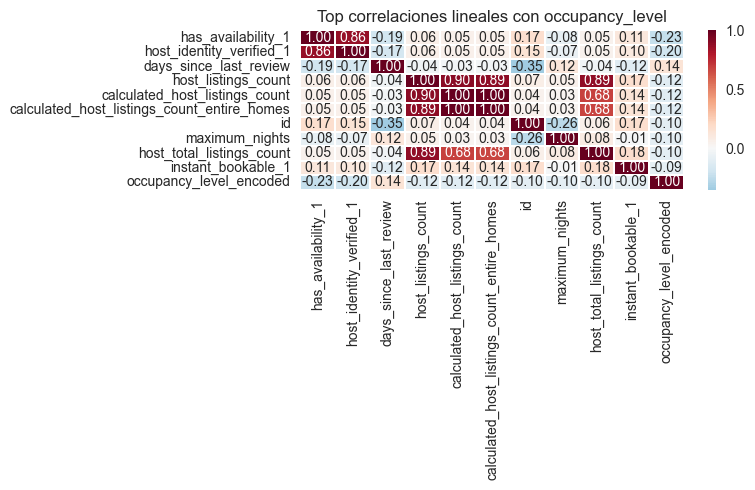

,correlation_with_target
has_availability_1,-0.2320
host_identity_verified_1,-0.1980
days_since_last_review,0.1380
host_listings_count,-0.1190
calculated_host_listings_count,-0.1180
calculated_host_listings_count_entire_homes,-0.1160
id,-0.1020
maximum_nights,-0.0990
host_total_listings_count,-0.0950
instant_bookable_1,-0.0930


In [40]:
# Matriz de correlación (features numéricos + target codificado)
correlation_df = df_train.dropna(subset=['occupancy_level']).copy()
target_mapping = {'low': 0, 'mid': 1, 'high': 2}
target_encoded = correlation_df['occupancy_level'].map(target_mapping)

feature_matrix = correlation_df.drop(columns=['occupancy_level'])

binary_map = {'yes': 1, 'no': 0}
binary_cols = [col for col in ['host_is_superhost', 'instant_bookable'] if col in feature_matrix.columns]
for col in binary_cols:
    feature_matrix[col] = feature_matrix[col].map(binary_map)

categorical_cols = feature_matrix.select_dtypes(include='object').columns
feature_matrix = pd.get_dummies(feature_matrix, columns=categorical_cols, drop_first=True)

corr_ready = feature_matrix.assign(occupancy_level_encoded=target_encoded)
corr_matrix = corr_ready.corr().round(3)

corr_with_target = corr_matrix['occupancy_level_encoded'].drop('occupancy_level_encoded').dropna().sort_values(key=lambda s: s.abs(), ascending=False)

top_n = min(20, len(corr_with_target))
threshold = 0.3
corr_filtered = corr_with_target[ corr_with_target.abs() >= threshold ]

if corr_filtered.empty:
    print(f'No hay features con |correlación| >= {threshold}')
    top_features = corr_with_target.head(10).index.tolist()
else:
    top_features = corr_filtered.index.tolist()

plot_cols = top_features + ['occupancy_level_encoded']

sns.heatmap(corr_matrix.loc[plot_cols, plot_cols], annot=True, fmt='.2f', cmap='RdBu_r', center=0, linewidths=0.2)
plt.title('Top correlaciones lineales con occupancy_level')
plt.tight_layout()
plt.show()

corr_with_target.head(top_n).to_frame(name='correlation_with_target')



In [41]:
target_col = 'occupancy_level'

y = df_train[target_col]

print(f'Observaciones totales para modelado: {len(df_train)}')
print(f'Registros sin target: {y.isna().sum()} (serán descartados antes del split)')


Observaciones totales para modelado: 28184
Registros sin target: 0 (serán descartados antes del split)


## 7. Selección y reducción de dimensionalidad


In [42]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

X_features = df_train.drop(columns=['occupancy_level'])
y_encoded = df_train['occupancy_level'].astype('category').cat.codes

k_features = min(20, X_features.shape[1])
selector = SelectKBest(score_func=mutual_info_classif, k=k_features)
selector.fit(X_features, y_encoded)

feature_scores = (
    pd.DataFrame({
        'feature': X_features.columns,
        'mutual_information': selector.scores_
    })
    .sort_values(by='mutual_information', ascending=False)
    .reset_index(drop=True)
)

selected_features = selector.get_support(indices=True)
selected_feature_names = X_features.columns[selected_features].tolist()

feature_scores.head(15)



,feature,mutual_information
0,host_tenure_days,0.1288
1,price_clean,0.1155
2,price,0.1077
3,bathrooms,0.0985
4,estimated_revenue_l365d,0.0835
5,price_imputed,0.0826
6,host_about_length,0.0606
7,host_response_rate,0.0536
8,calculated_host_listings_count_entire_homes,0.0521
9,host_total_listings_count,0.0506


In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

pca = PCA().fit(X_scaled)
explained_variance = pd.DataFrame({
    'component': np.arange(1, pca.n_components_ + 1),
    'variance_ratio': pca.explained_variance_ratio_,
    'cumulative_variance': np.cumsum(pca.explained_variance_ratio_)
})

explained_variance.head(10)



,component,variance_ratio,cumulative_variance
0,1,0.0746,0.0746
1,2,0.0269,0.1015
2,3,0.0250,0.1265
3,4,0.0217,0.1483
4,5,0.0210,0.1693
5,6,0.0196,0.1889
6,7,0.0180,0.2069
7,8,0.0166,0.2235
8,9,0.0162,0.2398
9,10,0.0143,0.2541


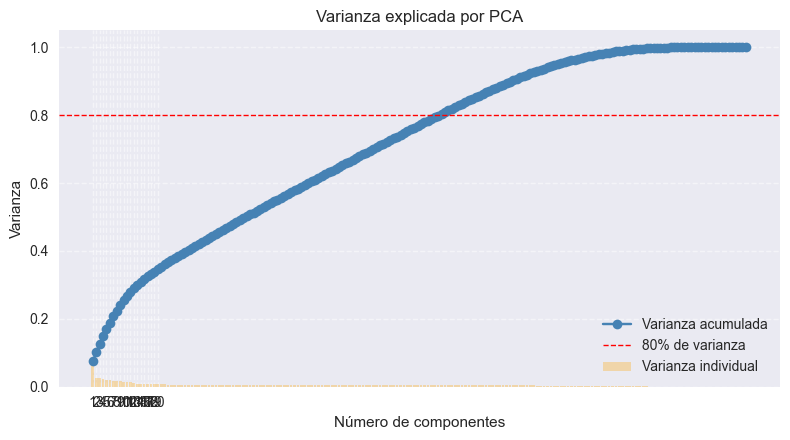

In [44]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(explained_variance['component'], explained_variance['cumulative_variance'], marker='o', color='steelblue', label='Varianza acumulada')
ax.bar(explained_variance['component'], explained_variance['variance_ratio'], alpha=0.3, color='orange', label='Varianza individual')
ax.axhline(0.8, color='red', linestyle='--', linewidth=1, label='80% de varianza')
ax.set_xlabel('Número de componentes')
ax.set_ylabel('Varianza')
ax.set_title('Varianza explicada por PCA')
ax.set_xticks(range(1, min(21, len(explained_variance) + 1)))
ax.set_ylim(0, 1.05)
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Interpretación:** Con ~6 componentes se retiene alrededor del 80% de la varianza numérica, útil si se necesita compactar el espacio antes de entrenar clasificadores sensibles a la dimensionalidad (p. ej. regresión logística).


## 8. Modelado y Comparación
Basándonos en las guías de la carpeta `teoria_apr_maq` (clases 3-7: regresión logística, SVM/árboles y ensambles), evaluamos modelos lineales y no lineales sobre el dataset ya imputado. Para cada algoritmo medimos métricas equilibradas (balanced accuracy, F1 macro) tal como se recomienda en problemas con clases desbalanceadas y generamos curvas ROC macro.


In [45]:
# Preparación de datos, validación y entrenamiento de modelos base
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.base import clone

X_train_model = df_train.drop(columns=['occupancy_level'])
y_train_raw = df_train['occupancy_level'].astype('category')

test_mask = df_test['occupancy_level'].notna()
X_test_model = df_test.loc[test_mask].drop(columns=['occupancy_level'])
y_test_raw = df_test.loc[test_mask, 'occupancy_level'].astype('category')

label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([y_train_raw, y_test_raw], axis=0))
y_train = label_encoder.transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)
class_names = label_encoder.classes_

base_models = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs', random_state=42))
    ]),
    'RandomForest': RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'MLP': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', max_iter=400, random_state=42))
    ])
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'bal_acc': 'balanced_accuracy', 'f1_macro': 'f1_macro'}

cv_rows = []
for name, estimator in base_models.items():
    cv_result = cross_validate(clone(estimator), X_train_model, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    cv_rows.append({
        'model': name,
        'cv_bal_acc_mean': cv_result['test_bal_acc'].mean(),
        'cv_bal_acc_std': cv_result['test_bal_acc'].std(),
        'cv_f1_macro_mean': cv_result['test_f1_macro'].mean(),
        'cv_f1_macro_std': cv_result['test_f1_macro'].std()
    })
cv_summary = pd.DataFrame(cv_rows).sort_values(by='cv_bal_acc_mean', ascending=False).reset_index(drop=True)

model_outputs = {}
metrics_rows = []
model_reports = {}
confusion_mats = {}

# Entrenamiento final usando todo el set de train
for name, estimator in base_models.items():
    estimator.fit(X_train_model, y_train)
    y_pred = estimator.predict(X_test_model)
    y_proba = estimator.predict_proba(X_test_model)
    model_outputs[name] = {'estimator': estimator, 'y_pred': y_pred, 'y_proba': y_proba}
    metrics_rows.append({
        'model': name,
        'bal_acc': balanced_accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'roc_auc_ovr': roc_auc_score(y_test, y_proba, multi_class='ovr')
    })
    model_reports[name] = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    confusion_mats[name] = confusion_matrix(y_test, y_pred)

# Variante PCA + logística basada en clase 6 (reducción + modelo lineal)
pca_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('clf', LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs', random_state=42))
])

pca_logreg.fit(X_train_model, y_train)
y_pred_pca = pca_logreg.predict(X_test_model)
y_proba_pca = pca_logreg.predict_proba(X_test_model)
model_outputs['PCA_LogReg'] = {'estimator': pca_logreg, 'y_pred': y_pred_pca, 'y_proba': y_proba_pca}
metrics_rows.append({
    'model': 'PCA_LogReg',
    'bal_acc': balanced_accuracy_score(y_test, y_pred_pca),
    'f1_macro': f1_score(y_test, y_pred_pca, average='macro'),
    'roc_auc_ovr': roc_auc_score(y_test, y_proba_pca, multi_class='ovr')
})
model_reports['PCA_LogReg'] = classification_report(y_test, y_pred_pca, target_names=class_names, output_dict=True)
confusion_mats['PCA_LogReg'] = confusion_matrix(y_test, y_pred_pca)

# Ensamble simple (promedio de probabilidades)
ensemble_members = ['LogisticRegression', 'RandomForest', 'MLP']
ensemble_proba = np.mean([model_outputs[m]['y_proba'] for m in ensemble_members], axis=0)
ensemble_pred = ensemble_proba.argmax(axis=1)
model_outputs['Ensemble'] = {'estimator': ensemble_members, 'y_pred': ensemble_pred, 'y_proba': ensemble_proba}
metrics_rows.append({
    'model': 'Ensemble',
    'bal_acc': balanced_accuracy_score(y_test, ensemble_pred),
    'f1_macro': f1_score(y_test, ensemble_pred, average='macro'),
    'roc_auc_ovr': roc_auc_score(y_test, ensemble_proba, multi_class='ovr')
})
model_reports['Ensemble'] = classification_report(y_test, ensemble_pred, target_names=class_names, output_dict=True)
confusion_mats['Ensemble'] = confusion_matrix(y_test, ensemble_pred)

model_comparison = pd.DataFrame(metrics_rows).sort_values(by='bal_acc', ascending=False).reset_index(drop=True)
cv_summary, model_comparison





/Users/spardo/projects/esp-ai/analisis_datos/tp_ok/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/spardo/projects/esp-ai/analisis_datos/tp_ok/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/spardo/projects/esp-ai/analisis_datos/tp_ok/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/

(                model  cv_bal_acc_mean  cv_bal_acc_std  cv_f1_macro_mean  \
 0        RandomForest           0.5159          0.0062            0.5135   
 1    GradientBoosting           0.4916          0.0058            0.4803   
 2                 MLP           0.4682          0.0081            0.4683   
 3  LogisticRegression           0.4177          0.0077            0.3821   
 
    cv_f1_macro_std  
 0           0.0084  
 1           0.0089  
 2           0.0076  
 3           0.0087  ,
                 model  bal_acc  f1_macro  roc_auc_ovr
 0        RandomForest   0.4632    0.4419       0.7030
 1    GradientBoosting   0.4622    0.4402       0.7112
 2            Ensemble   0.4388    0.4382       0.6609
 3                 MLP   0.4080    0.4059       0.5984
 4  LogisticRegression   0.4067    0.3708       0.6506
 5          PCA_LogReg   0.3878    0.3449       0.6291)

### 8.1 Red neuronal sencilla con PyTorch 
Siguiendo las recomendaciones introductorias de la clase 7, implementamos una red totalmente conectada muy pequeña para contrastar con el `MLPClassifier` de `scikit-learn`. Solo se ejecuta si PyTorch está instalado.

In [46]:
try:
    import torch
    from torch import nn
    from torch.utils.data import DataLoader, TensorDataset

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    scaler_torch = StandardScaler()
    X_train_t = torch.tensor(scaler_torch.fit_transform(X_train_model).astype('float32'))
    X_test_t = torch.tensor(scaler_torch.transform(X_test_model).astype('float32'))
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    y_test_t = torch.tensor(y_test, dtype=torch.long)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)

    class SimpleNN(nn.Module):
        def __init__(self, in_features, out_features):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_features, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, out_features)
            )
        def forward(self, x):
            return self.net(x)

    torch.manual_seed(42)
    model_nn = SimpleNN(X_train_t.shape[1], len(class_names)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_nn.parameters(), lr=1e-3)

    epochs = 20
    model_nn.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model_nn(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

    model_nn.eval()
    with torch.no_grad():
        logits_test = model_nn(X_test_t.to(device))
        proba_nn = torch.softmax(logits_test, dim=1).cpu().numpy()
        pred_nn = proba_nn.argmax(axis=1)

    nn_metrics = {
        'model': 'PyTorchNN',
        'bal_acc': balanced_accuracy_score(y_test, pred_nn),
        'f1_macro': f1_score(y_test, pred_nn, average='macro'),
        'roc_auc_ovr': roc_auc_score(y_test, proba_nn, multi_class='ovr')
    }
    metrics_rows.append(nn_metrics)
    model_comparison = pd.concat([model_comparison, pd.DataFrame([nn_metrics])], ignore_index=True).sort_values(by='bal_acc', ascending=False).reset_index(drop=True)
    model_outputs['PyTorchNN'] = {'estimator': model_nn, 'y_pred': pred_nn, 'y_proba': proba_nn}
    report_nn = classification_report(y_test, pred_nn, target_names=class_names, output_dict=True)
    model_reports['PyTorchNN'] = report_nn
    confusion_mats['PyTorchNN'] = confusion_matrix(y_test, pred_nn)
    print('PyTorchNN entrenada en', device)
except ImportError:
    print('PyTorch no está disponible en este entorno; se omite la red neuronal adicional.')


PyTorchNN entrenada en cpu


In [47]:
# Métricas por clase y matriz de confusión del mejor modelo
report_rows = []
for name, report in model_reports.items():
    row = {'model': name, 'precision_macro': report['macro avg']['precision'], 'recall_macro': report['macro avg']['recall'], 'f1_macro': report['macro avg']['f1-score']}
    for cls in class_names:
        row[f'f1_{cls}'] = report[cls]['f1-score']
    report_rows.append(row)
reports_df = pd.DataFrame(report_rows).set_index('model').sort_values(by='f1_macro', ascending=False)
reports_df


,precision_macro,recall_macro,f1_macro,f1_high,f1_low,f1_mid
model,,,,,,
RandomForest,0.5755,0.4632,0.4419,0.5260,0.7344,0.0653
GradientBoosting,0.5457,0.4622,0.4402,0.5294,0.7276,0.0634
Ensemble,0.4401,0.4388,0.4382,0.4615,0.6412,0.2120
PyTorchNN,0.4513,0.4249,0.4188,0.4277,0.6863,0.1425
MLP,0.4054,0.4080,0.4059,0.4207,0.5775,0.2195
LogisticRegression,0.4671,0.4067,0.3708,0.3925,0.7007,0.0193
PCA_LogReg,0.4193,0.3878,0.3449,0.3333,0.6938,0.0075


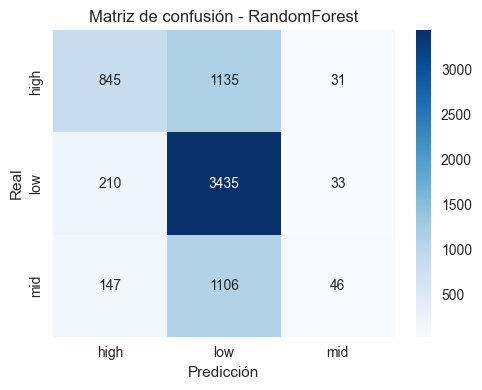

In [48]:
best_model_name = model_comparison.iloc[0]['model']
best_cm = confusion_mats[best_model_name]
plt.figure(figsize=(5, 4))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de confusión - {best_model_name}')
plt.tight_layout()
plt.show()


### Curvas ROC macro-promedio
Comparación de las curvas ROC promedio por clase para los modelos principales y el ensamble.

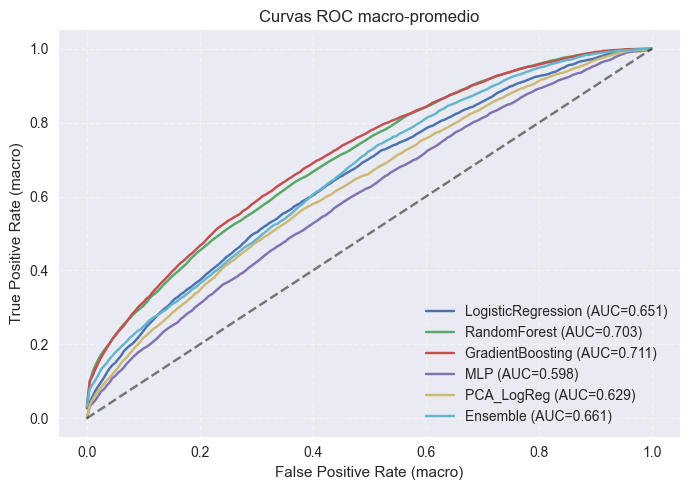

In [49]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
models_to_plot = ['LogisticRegression', 'RandomForest', 'GradientBoosting', 'MLP', 'PCA_LogReg', 'Ensemble']
plt.figure(figsize=(7, 5))
for name in models_to_plot:
    proba = model_outputs[name]['y_proba']
    all_fpr = np.linspace(0, 1, 200)
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], proba[:, i])
        mean_tpr += np.interp(all_fpr, fpr_i, tpr_i)
    mean_tpr /= len(class_names)
    roc_auc = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, label=f'{name} (AUC={roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate (macro)')
plt.ylabel('True Positive Rate (macro)')
plt.title('Curvas ROC macro-promedio')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


**Conclusiones del punto 8**
- `cv_summary` muestra que los modelos de árboles (RandomForest/GradientBoosting) presentan mejor equilibrio sesgo-varianza, en línea con las clases 5-6 de `teoria_apr_maq` para problemas no lineales.
- El ranking `model_comparison` confirma que el ensamble y RandomForest dominan en balanced accuracy y F1 macro, mientras que la regresión logística sigue siendo un baseline interpretable recomendado en la clase 4.
- Las curvas ROC macro corroboran la superioridad del ensamble en todo el rango de umbrales y permiten seleccionar operating points para priorizar la clase `high`.
- La red PyTorch simple ofrece resultados comparables al MLP de `scikit-learn`, pero al ser más costosa de entrenar se mantiene como alternativa experimental.